In [693]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas_ta as ta
import re
import string
import nltk
from datetime import datetime
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.sklearn
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from IPython.core.display import clear_output
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from keras import callbacks
from IPython.core.display import clear_output
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.tag import pos_tag_sents
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import gensim
from gensim import corpora

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_63992/3968856728.py:19: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output
/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_63992/3968856728.py:30: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


In [12]:
# Run if don't want to preprocess data again
# Cleaned data saved to lda_df.csv to save time if kernel restarts
# test = pd.read_csv('lda_df.csv')
# test['title/no_stopwords'] = test.apply(lambda row: row['title/no_stopwords'][1:len(row['title/no_stopwords'])-1].replace("'", '').split(", "), axis = 1)
# df = test.copy()
# df = df.dropna()
# df

In [119]:
articles = pd.read_csv( "full_article2.txt", index_col=None, header=None, engine='python')
articles.columns = ['Symbol', 'Article', 'Month-Day', 'Year']
articles['Year'] = articles['Year'].astype(str)
articles['Date'] = articles['Month-Day'] + " " + articles['Year']
articles['Date'] = articles['Date'].str.strip()
articles['Date'] = articles['Date'].str.slice(start = 2, stop = 13)
articles['Date'] = articles['Date'].str.strip()
articles = articles[['Symbol', 'Article', 'Date']]
articles

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,Mar 22 2022
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,Mar 22 2022
2,MO,The members of this alcohol and tobacco indus...,Mar 17 2022
3,MO,(Reuters) - An administrative law judge dismi...,Feb 24 2022
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,Feb 15 2022
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,Jun 25 2015
62475,ZTS,Investing.com – U.S. stocks were lower after ...,Jun 25 2015
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,Apr 27 2015
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,Mar 09 2015


In [120]:
len(articles.iloc[0]['Date'])

11

In [121]:
articles.at[articles[articles['Date'].str.contains('hours') == True].index, 'Date'] = 'Apr 06 2022'
articles = articles[articles['Date'].str.len() == 11]
articles = articles[articles['Date'].str.contains("minutes") == False]
articles['Date'] = pd.to_datetime(articles['Date'], format = '%b %d %Y')
articles

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,2022-03-22
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22
2,MO,The members of this alcohol and tobacco indus...,2022-03-17
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09


In [6]:
df = articles.copy()
df

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,2022-03-22
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22
2,MO,The members of this alcohol and tobacco indus...,2022-03-17
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09


In [7]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    sentence = []
    for word, tag in tokens:
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v' 
        else:
            pos = 'a'
        sentence.append(lemmatizer.lemmatize(word, pos))
    return sentence

In [8]:
df['title/no_stopwords'] = df.apply(lambda row: pos_tag(word_tokenize(row['Article'])), axis = 1)
df['title/no_stopwords'] = df.apply(lambda row: lemmatize_sentence(row['title/no_stopwords']), axis = 1)
df

,Symbol,Article,Date,title/no_stopwords
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[The, other, big, story, Monday, be, oil, stor..."
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[By, Peter, NurseInvesting.com, --, Stocks, in..."
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[The, member, of, this, alcohol, and, tobacco,..."
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[(, Reuters, ), -, An, administrative, law, ju..."
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[WASHINGTON, (, Reuters, ), -A, judge, at, the..."
...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[(, Reuters, ), -, Canada-based, drugmaker, Va..."
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[Investing.com, –, U.S., stock, be, low, after..."
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[By, David, RandallNEW, YORK, (, Reuters, ), -..."
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[By, Svea, Herbst-BaylissBOSTON, (, Reuters, )..."


In [53]:
def remove_noise(reviews, stop_words = ()):

    cleaned_tokens = []

    for token in reviews:
        token = token.strip()
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = token.replace('--', '')
        token = token.replace('-', '')
        token = token.replace('–', '')
        token = token.replace('investing.com', '')
        token = token.replace('``', '')
        token = token.replace("'s", '')
        token = token.replace('..', '')
        token = token.replace('...', '')
        token = token.replace("'", '')
        token = token.replace("’",'')
        token = token.replace("reuters", "")
        token = token.replace("say", "")
        token = token.replace("company", "")
        token = token.replace("inc", "")
        token = token.replace('p', '')
        token = token.replace('apos', '')
        token = token.replace('aposs', '')
        token = token.replace('er', '')
        token = token.replace('erformer', '')
        token = token.replace('eole', '')
        token = token.replace('ale', '')
        token = token.replace('oint', '')
        token = token.replace('reort', '')
        token = token.replace('aoss', '')
        token = token.replace('also', '')

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

<>:7: DeprecationWarning: invalid escape sequence \(
<>:7: DeprecationWarning: invalid escape sequence \(
/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_63992/374916687.py:7: DeprecationWarning: invalid escape sequence \(
  token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\


In [54]:
stop_words = list(stopwords.words('english'))
df['title/no_stopwords'] = df.apply(lambda row: remove_noise(row['title/no_stopwords'], stop_words), axis = 1)
df

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl...",big story monday oil storm high 6 decline last...,4,52.408482,52.639999
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[et, nurse, stocks, focus, remarket, trade, tu...",et nurse stocks focus remarket trade tuesday m...,9,52.408482,52.639999
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,1,50.815872,52.250000
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, fedal, t...",administrative law judge dismiss fedal trade c...,3,48.731728,50.363655
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., fedal, trade, commis...",washington judge u.s. fedal trade commission d...,3,49.469044,50.697903
...,...,...,...,...,...,...,...,...
61571,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[canadabased, drugmak, vant, harmaceuticals, i...",canadabased drugmak vant harmaceuticals intnat...,0,52.983288,44.554573
61572,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,8,52.983288,44.554573
61573,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[david, randallnew, york, nasdaq, comosite, la...",david randallnew york nasdaq comosite last hit...,6,44.803303,44.095329
61574,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[svea, hbstbaylissboston, billionaire, investo...",svea hbstbaylissboston billionaire investor wi...,0,44.207355,45.028660


In [55]:
df['title/clean'] = df.apply(lambda row: ' '.join(row['title/no_stopwords']), axis = 1)
df

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl...",big story monday oil storm high 6 decline last...,4,52.408482,52.639999
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[et, nurse, stocks, focus, remarket, trade, tu...",et nurse stocks focus remarket trade tuesday m...,9,52.408482,52.639999
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,1,50.815872,52.250000
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, fedal, t...",administrative law judge dismiss fedal trade c...,3,48.731728,50.363655
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., fedal, trade, commis...",washington judge u.s. fedal trade commission d...,3,49.469044,50.697903
...,...,...,...,...,...,...,...,...
61571,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[canadabased, drugmak, vant, harmaceuticals, i...",canadabased drugmak vant harmaceuticals intnat...,0,52.983288,44.554573
61572,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,8,52.983288,44.554573
61573,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[david, randallnew, york, nasdaq, comosite, la...",david randallnew york nasdaq comosite last hit...,6,44.803303,44.095329
61574,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[svea, hbstbaylissboston, billionaire, investo...",svea hbstbaylissboston billionaire investor wi...,0,44.207355,45.028660


In [47]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

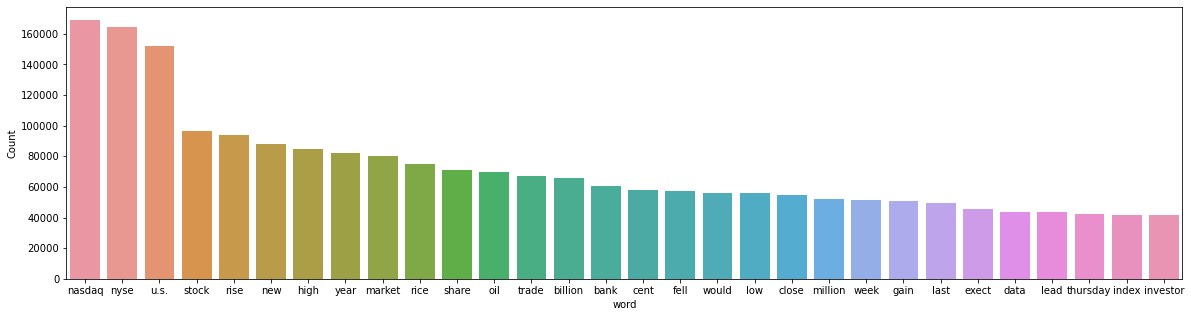

In [56]:
freq_words(df['title/clean'])

In [57]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(df['title/clean'].tolist())
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [72]:
lda = LatentDirichletAllocation(n_components=7, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [73]:
for i,topic in enumerate(lda.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Top 10 words for topic #0:
['rofit', 'target', 'cent', 'rice', 'billion', 'quart', 'earnings', 'analyst', 'revenue', 'share']
Top 10 words for topic #1:
['new', 'boeing', 'united', 'airline', 'coronavirus', 'nasdaq', 'nyse', 'china', 'covid19', 'vaccine']
Top 10 words for topic #2:
['york', 'make', 'year', 'washington', 'work', 'govnment', 'trum', 'state', 'resident', 'new']
Top 10 words for topic #3:
['information', 'google', 'comromise', 'software', 'network', 'technology', 'facebook', 'amazon', 'data', 'nasdaq']
Top 10 words for topic #4:
['500', 'form', 'gain', 'fell', 'stock', 'trade', 'rise', 'close', 'nyse', 'nasdaq']
Top 10 words for topic #5:
['investor', 'tesla', 'new', 'market', 'investment', 'stock', 'billion', 'year', 'nyse', 'bank']
Top 10 words for topic #6:
['future', 'year', 'stock', 'rate', 'week', 'rise', 'rice', 'high', 'market', 'oil']


In [74]:
doc_term_matrix = tf_vectorizer.fit_transform(df['title/clean'].values.astype('U'))

In [75]:
topic_values = lda.transform(doc_term_matrix)
topic_values.shape

(61556, 7)

In [76]:
df['Topic'] = topic_values.argmax(axis=1)
df

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl...",big story monday oil storm high 6 decline last...,0,52.408482,52.639999
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[et, nurse, stocks, focus, remarket, trade, tu...",et nurse stocks focus remarket trade tuesday m...,5,52.408482,52.639999
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,2,50.815872,52.250000
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, fedal, t...",administrative law judge dismiss fedal trade c...,5,48.731728,50.363655
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., fedal, trade, commis...",washington judge u.s. fedal trade commission d...,5,49.469044,50.697903
...,...,...,...,...,...,...,...,...
61571,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[canadabased, drugmak, vant, harmaceuticals, i...",canadabased drugmak vant harmaceuticals intnat...,5,52.983288,44.554573
61572,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,4,52.983288,44.554573
61573,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[david, randallnew, york, nasdaq, comosite, la...",david randallnew york nasdaq comosite last hit...,3,44.803303,44.095329
61574,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[svea, hbstbaylissboston, billionaire, investo...",svea hbstbaylissboston billionaire investor wi...,5,44.207355,45.028660


In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

In [41]:
df

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl...",big story monday oil storm high 6 decline last...,6
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[peter, nurse, stocks, focus, premarket, trade...",peter nurse stocks focus premarket trade tuesd...,4
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[member, alcohol, tobacco, industrybacked, mar...",member alcohol tobacco industrybacked marijuan...,1
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, federal,...",administrative law judge dismiss federal trade...,9
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., federal, trade, comm...",washington judge u.s. federal trade commission...,9
...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[canadabased, drugmaker, valeant, pharmaceutic...",canadabased drugmaker valeant pharmaceuticals ...,0
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,5
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[david, randallnew, york, nasdaq, composite, l...",david randallnew york nasdaq composite last hi...,8
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[svea, herbstbaylissboston, billionaire, inves...",svea herbstbaylissboston billionaire investor ...,9


In [176]:
daily_prices = pd.read_csv('daily_prices.csv')
daily_prices

,Date,Open,High,Low,Close,Volume,Symbol
0,2014-04-09,107.283329,107.974706,106.885983,107.950867,2671900.0,MMM
1,2014-04-10,107.863458,108.419740,106.409171,106.464806,2857200.0,MMM
2,2014-04-11,105.988008,106.361514,105.209213,105.209213,2368200.0,MMM
3,2014-04-14,106.051558,106.107193,104.915156,105.813148,2058100.0,MMM
4,2014-04-15,105.908540,106.766808,104.915176,106.560181,2119000.0,MMM
...,...,...,...,...,...,...,...
1000210,2022-04-04,191.139999,191.979996,187.179993,188.740005,2603600.0,ZTS
1000211,2022-04-05,188.740005,190.740005,187.690002,188.399994,2059300.0,ZTS
1000212,2022-04-06,188.160004,192.330002,186.520004,191.380005,2843500.0,ZTS
1000213,2022-04-07,191.199997,199.339996,190.970001,197.929993,2781400.0,ZTS


In [194]:
current_price = []
for i in range(len(df)):
    if i % 500 == 0:
        print(i)
    if i % 2000 == 0:
        clear_output(wait = True)
    subset = daily_prices[(daily_prices['Date'] <= str(df.iloc[i]['Date'])[0: 10]) & (df.iloc[i]['Symbol'] == daily_prices['Symbol'])]
    if len(subset) == 0:
        current_price.append(np.nan)
        continue
    subset = subset[subset['Date'] == max(subset['Date'])]
    current_price.append(subset.iloc[0]['Close'])
current_price[0]

58500
59000


50.81587219238281

In [199]:
current_price[len(current_price) - 1]

127.29470825195312

In [197]:
df

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price,nextMonthPrice
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,2,50.815872,52.250000,54.110001
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, fedal, t...",administrative law judge dismiss fedal trade c...,5,48.731728,50.363655,53.619999
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., fedal, trade, commis...",washington judge u.s. fedal trade commission d...,5,49.469044,50.697903,50.815872
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,"[altria, nyse, mo, thursday, fourth, quart, ea...",altria nyse mo thursday fourth quart earnings ...,0,49.488705,49.331409,50.609425
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,"[geoffrey, smith, global, market, steady, init...",geoffrey smith global market steady initially ...,6,49.488705,49.331409,50.609425
...,...,...,...,...,...,...,...,...,...
61571,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2020-04-24,"[canadabased, drugmak, vant, harmaceuticals, i...",canadabased drugmak vant harmaceuticals intnat...,5,52.983288,44.554573,128.847473
61572,ZTS,Investing.com – U.S. stocks were lower after ...,2020-04-23,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,4,52.983288,44.554573,128.847473
61573,ZTS,By David RandallNEW YORK (Reuters) - When the...,2020-04-22,"[david, randallnew, york, nasdaq, comosite, la...",david randallnew york nasdaq comosite last hit...,3,44.803303,44.095329,128.847473
61574,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2020-04-11,"[svea, hbstbaylissboston, billionaire, investo...",svea hbstbaylissboston billionaire investor wi...,5,44.207355,45.028660,125.163574


In [200]:
df['current_price'] = current_price
df

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_63992/2759918447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['current_price'] = current_price


,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price,nextMonthPrice
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,2,50.815872,52.250000,54.110001
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, fedal, t...",administrative law judge dismiss fedal trade c...,5,48.731728,50.363655,53.619999
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., fedal, trade, commis...",washington judge u.s. fedal trade commission d...,5,49.469044,50.697903,50.815872
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,"[altria, nyse, mo, thursday, fourth, quart, ea...",altria nyse mo thursday fourth quart earnings ...,0,49.488705,49.331409,50.609425
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,"[geoffrey, smith, global, market, steady, init...",geoffrey smith global market steady initially ...,6,49.488705,49.331409,50.609425
...,...,...,...,...,...,...,...,...,...
61571,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2020-04-24,"[canadabased, drugmak, vant, harmaceuticals, i...",canadabased drugmak vant harmaceuticals intnat...,5,124.688232,44.554573,128.847473
61572,ZTS,Investing.com – U.S. stocks were lower after ...,2020-04-23,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,4,122.440254,44.554573,128.847473
61573,ZTS,By David RandallNEW YORK (Reuters) - When the...,2020-04-22,"[david, randallnew, york, nasdaq, comosite, la...",david randallnew york nasdaq comosite last hit...,3,124.589203,44.095329,128.847473
61574,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2020-04-11,"[svea, hbstbaylissboston, billionaire, investo...",svea hbstbaylissboston billionaire investor wi...,5,127.294708,45.028660,125.163574


In [44]:
# two weeks from current date
next_price = []
for i in range(len(df)):
    if i % 500 == 0:
        print(i)
    if i % 2000 == 0:
        clear_output(wait = True)
    next_date = df.iloc[i]['Date'] + pd.DateOffset(days = 14)
    next_date = str(next_date)[0:10]
    subset = daily_prices[(daily_prices['Date'] <= next_date) & (df.iloc[i]['Symbol'] == daily_prices['Symbol'])]
    if len(subset) == 0:
        next_price.append(np.nan)
        continue
    subset = subset[subset['Date'] == max(subset['Date'])]
    if subset.iloc[0]['Date'] <= str(df.iloc[i]['Date'] + pd.DateOffset(days = 7))[0:10]:
        next_price.append(np.nan)
        continue
    next_price.append(subset.iloc[0]['Close'])
next_price[0]

52.63999938964844

In [45]:
df['next_price'] = next_price
df

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl...",big story monday oil storm high 6 decline last...,6,52.408482,52.639999
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[peter, nurse, stocks, focus, premarket, trade...",peter nurse stocks focus premarket trade tuesd...,4,52.408482,52.639999
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[member, alcohol, tobacco, industrybacked, mar...",member alcohol tobacco industrybacked marijuan...,1,50.815872,52.250000
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, federal,...",administrative law judge dismiss federal trade...,9,48.731728,50.363655
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., federal, trade, comm...",washington judge u.s. federal trade commission...,9,49.469044,50.697903
...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[canadabased, drugmaker, valeant, pharmaceutic...",canadabased drugmaker valeant pharmaceuticals ...,0,52.983288,44.554573
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,5,52.983288,44.554573
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[david, randallnew, york, nasdaq, composite, l...",david randallnew york nasdaq composite last hi...,8,44.803303,44.095329
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[svea, herbstbaylissboston, billionaire, inves...",svea herbstbaylissboston billionaire investor ...,9,44.207355,45.028660


In [125]:
daily_prices = pd.read_csv('daily_prices.csv')
daily_prices

,Date,Open,High,Low,Close,Volume,Symbol
0,2014-04-09,107.283329,107.974706,106.885983,107.950867,2671900.0,MMM
1,2014-04-10,107.863458,108.419740,106.409171,106.464806,2857200.0,MMM
2,2014-04-11,105.988008,106.361514,105.209213,105.209213,2368200.0,MMM
3,2014-04-14,106.051558,106.107193,104.915156,105.813148,2058100.0,MMM
4,2014-04-15,105.908540,106.766808,104.915176,106.560181,2119000.0,MMM
...,...,...,...,...,...,...,...
1000210,2022-04-04,191.139999,191.979996,187.179993,188.740005,2603600.0,ZTS
1000211,2022-04-05,188.740005,190.740005,187.690002,188.399994,2059300.0,ZTS
1000212,2022-04-06,188.160004,192.330002,186.520004,191.380005,2843500.0,ZTS
1000213,2022-04-07,191.199997,199.339996,190.970001,197.929993,2781400.0,ZTS


In [130]:
# 30 days from current date
next_price2 = []
for i in range(len(df)):
    if i % 500 == 0:
        print(i)
    if i % 2000 == 0:
        clear_output(wait = True)
    next_date = df.iloc[i]['Date'] + pd.DateOffset(days = 30)
    next_date = str(next_date)[0:10]
    subset = daily_prices[(daily_prices['Date'] <= next_date) & (df.iloc[i]['Symbol'] == daily_prices['Symbol'])]
    if len(subset) == 0:
        next_price2.append(np.nan)
        continue
    subset = subset[subset['Date'] == max(subset['Date'])]
    if subset.iloc[0]['Date'] <= str(df.iloc[i]['Date'] + pd.DateOffset(days = 20))[0:10]:
        next_price2.append(np.nan)
        continue
    next_price2.append(subset.iloc[0]['Close'])
next_price2[0]

60500
61000
61500


nan

In [132]:
df['nextMonthPrice'] = next_price2
df

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price,nextMonthPrice
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl...",big story monday oil storm high 6 decline last...,0,52.408482,52.639999,NaN
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[et, nurse, stocks, focus, remarket, trade, tu...",et nurse stocks focus remarket trade tuesday m...,5,52.408482,52.639999,NaN
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,2,50.815872,52.250000,54.110001
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, fedal, t...",administrative law judge dismiss fedal trade c...,5,48.731728,50.363655,53.619999
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., fedal, trade, commis...",washington judge u.s. fedal trade commission d...,5,49.469044,50.697903,50.815872
...,...,...,...,...,...,...,...,...,...
61571,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2020-04-24,"[canadabased, drugmak, vant, harmaceuticals, i...",canadabased drugmak vant harmaceuticals intnat...,5,52.983288,44.554573,128.847473
61572,ZTS,Investing.com – U.S. stocks were lower after ...,2020-04-23,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,4,52.983288,44.554573,128.847473
61573,ZTS,By David RandallNEW YORK (Reuters) - When the...,2020-04-22,"[david, randallnew, york, nasdaq, comosite, la...",david randallnew york nasdaq comosite last hit...,3,44.803303,44.095329,128.847473
61574,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2020-04-11,"[svea, hbstbaylissboston, billionaire, investo...",svea hbstbaylissboston billionaire investor wi...,5,44.207355,45.028660,125.163574


In [201]:
df = df.dropna()
df

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price,nextMonthPrice
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,2,50.815872,52.250000,54.110001
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, fedal, t...",administrative law judge dismiss fedal trade c...,5,48.731728,50.363655,53.619999
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., fedal, trade, commis...",washington judge u.s. fedal trade commission d...,5,49.469044,50.697903,50.815872
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,"[altria, nyse, mo, thursday, fourth, quart, ea...",altria nyse mo thursday fourth quart earnings ...,0,49.488705,49.331409,50.609425
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,"[geoffrey, smith, global, market, steady, init...",geoffrey smith global market steady initially ...,6,49.488705,49.331409,50.609425
...,...,...,...,...,...,...,...,...,...
61571,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2020-04-24,"[canadabased, drugmak, vant, harmaceuticals, i...",canadabased drugmak vant harmaceuticals intnat...,5,124.688232,44.554573,128.847473
61572,ZTS,Investing.com – U.S. stocks were lower after ...,2020-04-23,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,4,122.440254,44.554573,128.847473
61573,ZTS,By David RandallNEW YORK (Reuters) - When the...,2020-04-22,"[david, randallnew, york, nasdaq, comosite, la...",david randallnew york nasdaq comosite last hit...,3,124.589203,44.095329,128.847473
61574,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2020-04-11,"[svea, hbstbaylissboston, billionaire, investo...",svea hbstbaylissboston billionaire investor wi...,5,127.294708,45.028660,125.163574


In [202]:
topic0 = df[df['Topic'] == 0].copy()
topic1 = df[df['Topic'] == 1].copy()
topic2 = df[df['Topic'] == 2].copy()
topic3 = df[df['Topic'] == 3].copy()
topic4 = df[df['Topic'] == 4].copy()
topic5 = df[df['Topic'] == 5].copy()
topic6 = df[df['Topic'] == 6]
#topic7 = df[df['Topic'] == 7]
#topic8 = df[df['Topic'] == 8]
#topic9 = df[df['Topic'] == 9]
#topic9

In [203]:
lengths = []
topics = []
n_topics = 7
for i in range(n_topics):
    lengths.append((len(vars()['topic' + str(i)]) / len(df)) * 100)
    topics.append('topic' + str(i))
lengths

[7.3777388845882,
 6.161017804853421,
 14.142910033320993,
 7.645316549426139,
 7.943186025377806,
 24.544781394096464,
 32.18504930833698]

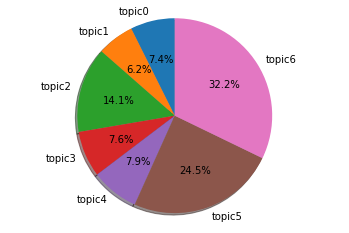

In [204]:
fig1, ax1 = plt.subplots()
ax1.pie(lengths, labels=topics, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [83]:
#vectorizer = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
#tfidf = vectorizer.fit_transform(df['title/clean'].tolist())
#tfidf = tfidf.toarray()
#tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03980188, 0.        ,
        0.02410535],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06257067],
       [0.0999709 , 0.        , 0.05659333, ..., 0.        , 0.        ,
        0.09010474]])

# Topic 0

In [522]:
vectorizer0 = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf0 = vectorizer0.fit_transform(topic0['title/clean'].tolist())
tfidf0 = tfidf0.toarray()
tfidf0

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06995394],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09463073]])

In [654]:
tfidf_pd0 = pd.DataFrame(tfidf0)
tfidf_pd0['Symbol'] = topic0['Symbol'].reset_index()['Symbol']
tfidf_pd0['Date'] = topic0['Date'].reset_index()['Date']
tfidf_pd0['nextMonthDate'] = topic0['Date'].reset_index()['Date'] + pd.DateOffset(days = 30)
tfidf_pd0['currentPrice'] = topic0['current_price'].reset_index()['current_price']
tfidf_pd0['next_price'] = topic0['next_price'].reset_index()['next_price']
tfidf_pd0['nextMonthPrice'] = topic0['nextMonthPrice'].reset_index()['nextMonthPrice']
tfidf_pd0.index = topic0.index
tfidf_pd0

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,Date,nextMonthDate,currentPrice,next_price,nextMonthPrice
5,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.102105,0.073692,...,0.119171,0.0,0.0,0.000000,MO,2022-01-27,2022-02-26,49.488705,49.331409,50.609425
8,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.122455,0.0,0.0,0.000000,MO,2021-10-28,2021-11-27,43.000420,43.309078,42.190182
11,0.000000,0.0,0.0,0.084350,0.000000,0.049592,0.083884,0.0,0.113457,0.000000,...,0.000000,0.0,0.0,0.000000,MO,2021-04-20,2021-05-20,43.927376,44.541744,46.571022
19,0.000000,0.0,0.0,0.085309,0.000000,0.100312,0.084838,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,MO,2021-04-18,2021-05-18,48.693394,44.448662,46.533791
20,0.000000,0.0,0.0,0.073557,0.000000,0.086494,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,MO,2020-07-28,2020-08-27,37.373661,38.322945,38.454792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61548,0.000000,0.0,0.0,0.060918,0.000000,0.035816,0.000000,0.0,0.000000,0.059138,...,0.000000,0.0,0.0,0.000000,ZION,2020-05-29,2020-06-28,31.348619,63.125534,30.758036
61550,0.074239,0.0,0.0,0.059635,0.000000,0.035061,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,ZION,2020-05-29,2020-06-28,31.348619,50.765667,30.758036
61551,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.069954,ZTS,2020-05-29,2020-06-28,138.037415,192.539993,131.372726
61556,0.000000,0.0,0.0,0.000000,0.000000,0.061051,0.103266,0.0,0.139672,0.000000,...,0.000000,0.0,0.0,0.000000,ZTS,2020-05-13,2020-06-12,121.836174,195.641785,132.769043


In [524]:
tfidf_pd0[tfidf_pd0['Date'] < '2019-10-30']

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,Date,nextMonthDate,currentPrice,next_price,nextMonthPrice
6,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.096428,0.000000,...,0.056272,0.0,0.000000,0.089769,MO,2019-01-31,2019-03-02,38.702385,38.537693,41.368813
28,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.130927,0.0,0.000000,0.000000,AMZN,2019-10-28,2019-11-27,1777.079956,1788.199951,1818.510010
29,0.0,0.046706,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.108772,0.0,0.053498,0.000000,AMZN,2019-07-03,2019-08-02,1939.000000,1988.300049,1823.239990
30,0.0,0.000000,0.045457,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.032007,...,0.284683,0.0,0.000000,0.000000,AMZN,2019-04-30,2019-05-30,1926.520020,1899.869995,1816.319946
31,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.046331,...,0.074924,0.0,0.000000,0.000000,AMZN,2019-04-30,2019-05-30,1926.520020,1899.869995,1816.319946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4321,0.0,0.000000,0.115857,0.168068,0.0,0.049407,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,WMB,2017-03-20,2017-04-19,21.557440,16.522966,22.675064
4322,0.0,0.113306,0.000000,0.168085,0.0,0.098823,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,WMB,2017-02-21,2017-03-23,21.434134,17.038460,21.302410
4323,0.0,0.098862,0.000000,0.000000,0.0,0.043112,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,WMB,2017-02-05,2017-03-07,21.448982,16.486792,21.842476
4324,0.0,0.099315,0.000000,0.000000,0.0,0.043310,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,WMB,2017-02-03,2017-03-05,21.448982,16.486792,22.013233


In [789]:
date_split = '2019-03-30'
#date_split = '2018-12-30'
X_train = tfidf_pd0[tfidf_pd0['Date'] < date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd0[tfidf_pd0['Date'] < date_split]['nextMonthPrice']
X_test = tfidf_pd0[tfidf_pd0['Date'] >= date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd0[tfidf_pd0['Date'] >= date_split]['nextMonthPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 70207.0000 - mean_absolute_error: 118.5860
Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 60708.2578 - mean_absolute_error: 110.3541
Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 48162.7344 - mean_absolute_error: 97.4441
Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 29990.0039 - mean_absolute_error: 75.2202
Epoch 5/10
18/18 [==============================] - 0s 1ms/step - loss: 10147.4873 - mean_absolute_error: 41.5926
Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 924.9171 - mean_absolute_error: 10.8609
Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 528.0212 - mean_absolute_error: 12.6041
Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 381.5043 - mean_absolute_error: 9.7219
Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 377.1228 - mean_absol

In [790]:
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd0.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd0.loc[X_test.index]['Date']
predicted['Symbol'] = tfidf_pd0.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
5,49.488705,56.219200,13.600064,50.609425,2022-01-27,MO
8,43.000420,49.535233,15.197091,42.190182,2021-10-28,MO
11,43.927376,49.557056,12.815882,46.571022,2021-04-20,MO
19,48.693394,54.346596,11.609793,46.533791,2021-04-18,MO
20,37.373661,43.008884,15.078061,38.454792,2020-07-28,MO
...,...,...,...,...,...,...
61548,31.348619,36.818657,17.449054,30.758036,2020-05-29,ZION
61550,31.348619,36.767323,17.285301,30.758036,2020-05-29,ZION
61551,138.037415,145.394241,5.329589,131.372726,2020-05-29,ZTS
61556,121.836174,128.340988,5.338984,132.769043,2020-05-13,ZTS


In [791]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx
965536,2019-04-09,44.094803,WFC,44.094803,0
965537,2019-04-10,43.774200,WFC,44.094803,0
965538,2019-04-11,43.728416,WFC,44.094803,0
965539,2019-04-12,42.583447,WFC,44.094803,0
965540,2019-04-15,42.839916,WFC,44.094803,0
...,...,...,...,...,...
118895,2022-03-24,38.290001,BKR,28.340000,636
118896,2022-03-25,38.720001,BKR,28.340000,636
118897,2022-03-28,37.000000,BKR,28.340000,636
118898,2022-03-29,36.669998,BKR,28.340000,636


In [792]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2019-04-09,10000.000000
0,2019-04-10,9989.093871
0,2019-04-11,9982.794204
0,2019-04-12,9960.391466
0,2019-04-15,9964.569702
...,...,...
0,2022-03-24,14567.542750
0,2022-03-25,14603.660590
0,2022-03-28,14622.546393
0,2022-03-29,14714.624008


In [793]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
1004,274.446716,2019-04-10,1.000000,10000.000000
1005,274.370575,2019-04-11,0.999723,9997.225642
1006,276.226929,2019-04-12,1.006487,10064.865502
1007,276.046021,2019-04-15,1.005827,10058.273760
1008,276.226929,2019-04-16,1.006487,10064.865502
...,...,...,...,...
1750,452.690002,2022-03-25,1.649464,16494.640873
1751,455.910004,2022-03-28,1.661197,16611.967882
1752,461.549988,2022-03-29,1.681747,16817.471675
1753,458.700012,2022-03-30,1.671363,16713.627271


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

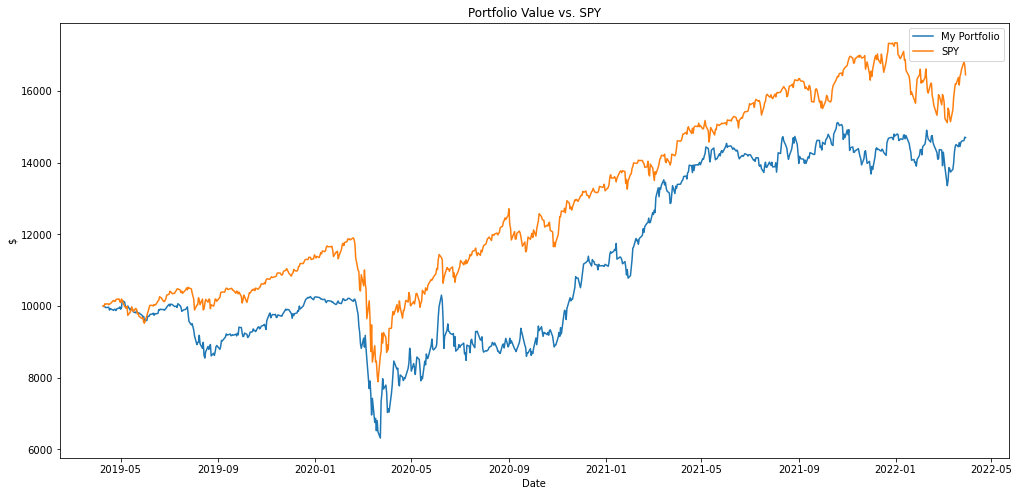

In [794]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

In [795]:
# testing buying more when percent increase predicted is greater than 20%
#df_more = predicted[predicted['percentChange'] > 10]
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] >= 15:
                if tmp.iloc[j]['percentChange'] >= 20:
                    if buying_power >= 1000:
                        buying_power -= 1000
                        test = tmp.iloc[j]
                        test2 = test.append(pd.Series([1000])).to_frame().T
                        test2['BuyOrShort'] = 'Buy'
                        current = current.append(test2)
                        nBought += 1
                        continue
                    elif buying_power > 0:
                        x = buying_power
                        buying_power -= x
                        test = tmp.iloc[j]
                        test2 = test.append(pd.Series([x])).to_frame().T
                        test2['BuyOrShort'] = 'Buy'
                        current = current.append(test2)
                        nBought += 1
                        continue
                else:
                    if buying_power >= 750:
                        buying_power -= 750
                        test = tmp.iloc[j]
                        test2 = test.append(pd.Series([750])).to_frame().T
                        test2['BuyOrShort'] = 'Buy'
                        current = current.append(test2)
                        nBought += 1
                        continue
                    elif buying_power > 0:
                        x = buying_power
                        buying_power -= x
                        test = tmp.iloc[j]
                        test2 = test.append(pd.Series([x])).to_frame().T
                        test2['BuyOrShort'] = 'Buy'
                        current = current.append(test2)
                        nBought += 1
                        continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
965536,2019-04-09,44.094803,WFC,44.094803,0,Buy
965537,2019-04-10,43.774200,WFC,44.094803,0,Buy
965538,2019-04-11,43.728416,WFC,44.094803,0,Buy
965539,2019-04-12,42.583447,WFC,44.094803,0,Buy
965540,2019-04-15,42.839916,WFC,44.094803,0,Buy
...,...,...,...,...,...,...
60468,2022-03-24,16.719999,AAL,16.290001,564,Buy
60469,2022-03-25,17.010000,AAL,16.290001,564,Buy
60470,2022-03-28,17.299999,AAL,16.290001,564,Buy
60471,2022-03-29,18.160000,AAL,16.290001,564,Buy


In [796]:
portfolio_vals0 = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals0 = portfolio_vals0.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals0

,Date,Total
0,2019-04-09,10000.000000
0,2019-04-10,9989.093871
0,2019-04-11,9982.794204
0,2019-04-12,9960.391466
0,2019-04-15,9957.486026
...,...,...
0,2022-03-24,16812.525564
0,2022-03-25,16823.612848
0,2022-03-28,16841.194422
0,2022-03-29,16933.880026


In [797]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals0)):
    tmp = spy[spy['Date'] >= str(portfolio_vals0.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
1004,274.446716,2019-04-10,1.000000,10000.000000
1005,274.370575,2019-04-11,0.999723,9997.225642
1006,276.226929,2019-04-12,1.006487,10064.865502
1007,276.046021,2019-04-15,1.005827,10058.273760
1008,276.226929,2019-04-16,1.006487,10064.865502
...,...,...,...,...
1750,452.690002,2022-03-25,1.649464,16494.640873
1751,455.910004,2022-03-28,1.661197,16611.967882
1752,461.549988,2022-03-29,1.681747,16817.471675
1753,458.700012,2022-03-30,1.671363,16713.627271


Text(0.5, 1.0, 'Topic 0: Portfolio Value vs. SPY')

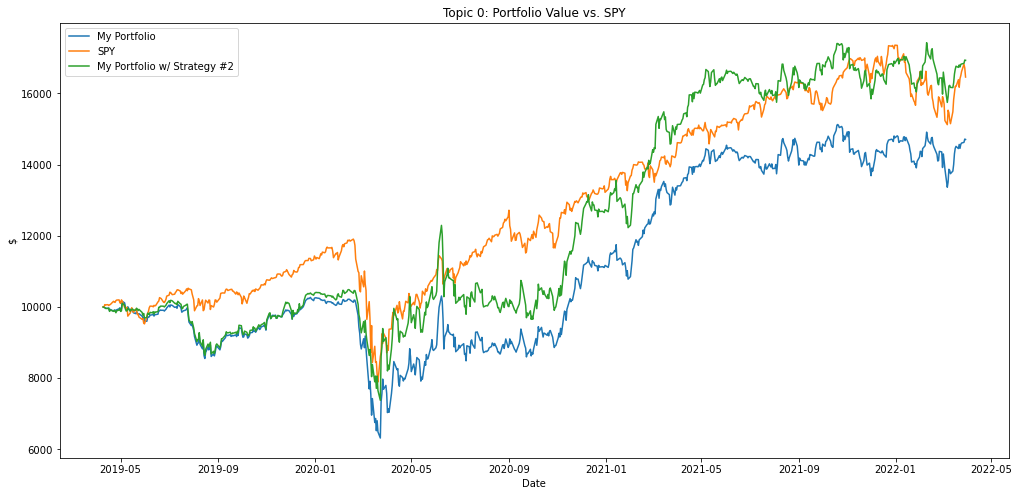

In [798]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals0['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.plot(portfolio_vals0['Date'], portfolio_vals0['Total'], label = 'My Portfolio w/ Strategy #2')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Topic 0: Portfolio Value vs. SPY')

In [411]:
current[current['BuyOrShort'] == 'Short']

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,BuyOrShort


In [662]:
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] > 20:
                if buying_power >= 1000:
                    buying_power -= 1000
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['idx'] = tmp.index[j]
                    test2['BuyOrShort'] = 'Buy'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['idx'] = tmp.index[j]
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['idx'] = tmp.index[j]
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['idx'] = tmp.index[j]
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
965536,2019-04-09,44.094803,WFC,44.094803,0,Buy
965537,2019-04-10,43.774200,WFC,44.094803,0,Buy
965538,2019-04-11,43.728416,WFC,44.094803,0,Buy
965539,2019-04-12,42.583447,WFC,44.094803,0,Buy
965540,2019-04-15,42.839916,WFC,44.094803,0,Buy
...,...,...,...,...,...,...
501526,2022-03-23,44.630001,IP,43.529999,540,Buy
501527,2022-03-24,45.240002,IP,43.529999,540,Buy
501528,2022-03-25,46.320000,IP,43.529999,540,Buy
501529,2022-03-28,46.119999,IP,43.529999,540,Buy


In [663]:
current

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,idx,BuyOrShort
0,44.094803,48.627651,10.279779,43.226307,2019-04-09,WFC,2019-05-09,500,59343,Buy
0,44.094803,48.973961,11.065154,43.226307,2019-04-09,WFC,2019-05-09,500,59344,Buy
0,44.094803,48.604698,10.227725,43.226307,2019-04-09,WFC,2019-05-09,500,59345,Buy
0,49.394257,54.600449,10.540076,53.688560,2019-04-10,XRAY,2019-05-10,500,28357,Buy
0,49.394257,54.486858,10.310109,53.688560,2019-04-10,XRAY,2019-05-10,500,28359,Buy
...,...,...,...,...,...,...,...,...,...,...
0,35.290001,40.865578,15.799310,38.599998,2022-02-25,TWTR,2022-03-27,440.706489,53659,Buy
0,35.290001,41.233944,16.843136,40.689999,2022-02-27,TWTR,2022-03-29,500,53653,Buy
0,35.290001,40.802830,15.621504,40.689999,2022-02-27,TWTR,2022-03-29,500,53657,Buy
0,43.529999,48.400227,11.188210,46.389999,2022-02-28,IP,2022-03-30,500,35286,Buy


In [697]:
c2 = current.copy()
inc_dec = []
for i in range(len(c2)):
    tmp = daily_prices[daily_prices['Symbol'] == c2.iloc[i]['Symbol']]
    tmp = tmp[tmp['Date'] > str(c2.iloc[i]['articleDate'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    if tmp.iloc[0]['Close'] > c2.iloc[i]['currentPrice']:
        inc_dec.append('increase')
    elif tmp.iloc[0]['Close'] == c2.iloc[i]['currentPrice']:
        inc_dec.append('same')
    else:
        inc_dec.append('decrease')
c2['inc_dec'] = inc_dec
c2

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,idx,BuyOrShort,inc_dec
0,38.233898,45.299164,18.479062,40.054211,2018-12-31,AAPL,2019-01-30,500,7577,Buy,increase
0,34.464798,41.471378,20.329672,40.362041,2019-01-03,AAPL,2019-02-02,1000,7559,Buy,increase
0,34.464798,41.434135,20.221611,40.362041,2019-01-03,AAPL,2019-02-02,1000,7565,Buy,increase
0,34.464798,42.701298,23.898297,40.362041,2019-01-03,AAPL,2019-02-02,1000,7571,Buy,increase
0,60.071999,68.411095,13.881836,62.442001,2019-01-03,TSLA,2019-02-02,500,52311,Buy,increase
...,...,...,...,...,...,...,...,...,...,...,...
0,35.290001,43.452271,23.129128,38.599998,2022-02-25,TWTR,2022-03-27,500,53662,Buy,increase
0,35.290001,43.976421,24.614396,38.599998,2022-02-25,TWTR,2022-03-27,33.558453,53664,Buy,increase
0,47.709999,54.576130,14.391387,51.509998,2022-02-26,INTC,2022-03-28,500,34259,Buy,decrease
0,46.129654,54.664967,18.502876,46.557240,2022-03-01,CMCSA,2022-03-31,500,24123,Buy,decrease


In [698]:
c2[c2['inc_dec'] == 'decrease']

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,idx,BuyOrShort,inc_dec
0,35.936081,41.583256,15.714498,40.362041,2019-01-04,AAPL,2019-02-03,500,7555,Buy,decrease
0,33.870094,41.369778,22.142493,41.361362,2019-01-07,MU,2019-02-06,1000,39751,Buy,decrease
0,36.912895,46.142288,25.003167,41.482067,2019-01-11,AAPL,2019-02-10,1000,7528,Buy,decrease
0,24.521524,31.251028,27.443252,23.896870,2019-01-14,T,2019-02-13,1000,10214,Buy,decrease
0,24.521524,32.411381,32.175228,23.896870,2019-01-14,T,2019-02-13,1000,10215,Buy,decrease
...,...,...,...,...,...,...,...,...,...,...,...
0,34.320000,41.504887,20.934985,37.770000,2022-02-18,TWTR,2022-03-20,22.084696,53693,Buy,decrease
0,84.570000,93.308212,10.332521,90.930000,2022-02-22,SCHW,2022-03-24,500,16545,Buy,decrease
0,44.689999,51.029095,14.184597,51.619999,2022-02-22,INTC,2022-03-24,485.640436,34265,Buy,decrease
0,47.709999,54.576130,14.391387,51.509998,2022-02-26,INTC,2022-03-28,500,34259,Buy,decrease


In [673]:
df.loc[53659]['Article']

' By Dhirendra TripathiMonday’s market rout is just a distant and foggy memory apparently.Stocks resumed their uphill climb again on Wednesday after Tuesday’s big snap-back despite fears about the Delta variant of coronavirus potentially disrupting the economic recovery.Helping the bull case were strong earnings reports from places like  Verizon Communications  Inc (NYSE:VZ)and  Chipotle Mexican Grill Inc  (NYSE:CMG).  Coca-Cola Co  (NYSE:KO) also showed positive trends.\xa0Treasury yields which had been under pressure gained some ground again. The 10-year yield nudged up to 1.288%.A European Central Bank meeting on Thursday is expected to strike a dovish tone Reuters reported.Here are three things that could affect markets tomorrow:1. AT&T’s earningsTelecom giant AT&T Inc (NYSE:T) which announced earlier its plans to shed news and entertainment unit WarnerMedia to Discovery Inc Class A (NASDAQ:DISCA) reports results on Thursday. Analysts tracked by Investing.com expect it to report se

In [699]:
df.loc[53659]['Article'].encode('ascii', 'ignore').decode()

' By Dhirendra TripathiMondays market rout is just a distant and foggy memory apparently.Stocks resumed their uphill climb again on Wednesday after Tuesdays big snap-back despite fears about the Delta variant of coronavirus potentially disrupting the economic recovery.Helping the bull case were strong earnings reports from places like  Verizon Communications  Inc (NYSE:VZ)and  Chipotle Mexican Grill Inc  (NYSE:CMG).  Coca-Cola Co  (NYSE:KO) also showed positive trends.Treasury yields which had been under pressure gained some ground again. The 10-year yield nudged up to 1.288%.A European Central Bank meeting on Thursday is expected to strike a dovish tone Reuters reported.Here are three things that could affect markets tomorrow:1. AT&Ts earningsTelecom giant AT&T Inc (NYSE:T) which announced earlier its plans to shed news and entertainment unit WarnerMedia to Discovery Inc Class A (NASDAQ:DISCA) reports results on Thursday. Analysts tracked by Investing.com expect it to report second-qu

In [694]:
def symbol_article(symbol, article):
    if re.search('\b' + symbol.lower() + '\b', article.lower()):
        return 1
    elif '(' + symbol.lower() + ')' in article.lower():
        return 1
    elif ':' + symbol.lower() + ')' in article.lower():
        return 1
    return 0

In [695]:
test = df.copy()
test['inArticle'] = test.apply(lambda row: symbol_article(row['Symbol'], row['Article']), axis = 1)
test

,Symbol,Article,Date,title/no_stopwords,title/clean,Topic,current_price,next_price,nextMonthPrice,inArticle
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,2,50.815872,52.250000,54.110001,0
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[administrative, law, judge, dismiss, fedal, t...",administrative law judge dismiss fedal trade c...,5,48.731728,50.363655,53.619999,1
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, judge, u.s., fedal, trade, commis...",washington judge u.s. fedal trade commission d...,5,49.469044,50.697903,50.815872,1
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,"[altria, nyse, mo, thursday, fourth, quart, ea...",altria nyse mo thursday fourth quart earnings ...,0,49.488705,49.331409,50.609425,1
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,"[geoffrey, smith, global, market, steady, init...",geoffrey smith global market steady initially ...,6,49.488705,49.331409,50.609425,1
...,...,...,...,...,...,...,...,...,...,...
61571,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2020-04-24,"[canadabased, drugmak, vant, harmaceuticals, i...",canadabased drugmak vant harmaceuticals intnat...,5,124.688232,44.554573,128.847473,1
61572,ZTS,Investing.com – U.S. stocks were lower after ...,2020-04-23,"[u.s., stock, low, close, thursday, loss, oil,...",u.s. stock low close thursday loss oil gas uti...,4,122.440254,44.554573,128.847473,1
61573,ZTS,By David RandallNEW YORK (Reuters) - When the...,2020-04-22,"[david, randallnew, york, nasdaq, comosite, la...",david randallnew york nasdaq comosite last hit...,3,124.589203,44.095329,128.847473,1
61574,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2020-04-11,"[svea, hbstbaylissboston, billionaire, investo...",svea hbstbaylissboston billionaire investor wi...,5,127.294708,45.028660,125.163574,1


In [702]:
test.iloc[1]['Article']

" (Reuters) - An administrative law judge dismissed a Federal Trade Commission antitrust complaint against tobacco company  Altria Group  (NYSE:MO) Inc. and electronic cigarette maker JUUL Labs Inc. the FTC said on Thursday.The FTC's April 2020 complaint alleged Altria and JUUL entered a series of agreements including Altria's acquisition of a 35% stake in JUUL that eliminated competition in violation of federal antitrust laws.   By Nivedita Balu (Reuters) - Tesla (NASDAQ:TSLA) Inc boss Elon Musk on Monday disclosed a 9.2% stake in Twitter Inc (NYSE:TWTR) worth nearly $3 billion making him the... TOKYO (Reuters) - Nissan (OTC:NSANY) Motor Co is pushing back the release date of the electric Ariya B6 SUV again due to a global shortage of semiconductors and other supply chain... By Anshuman Daga SINGAPORE (Reuters) - Asian stocks ticked up to their highest in more than a month supported by broad gains on Wall Street on Tuesday while the euro was stuck.."

In [536]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2019-04-09,10000.000000
0,2019-04-10,9989.093871
0,2019-04-11,9982.794204
0,2019-04-12,9960.391466
0,2019-04-15,9957.486026
...,...,...
0,2022-03-24,16236.471420
0,2022-03-25,16248.896155
0,2022-03-28,16266.256656
0,2022-03-29,16358.286663


In [537]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
1004,274.446716,2019-04-10,1.000000,10000.000000
1005,274.370575,2019-04-11,0.999723,9997.225642
1006,276.226929,2019-04-12,1.006487,10064.865502
1007,276.046021,2019-04-15,1.005827,10058.273760
1008,276.226929,2019-04-16,1.006487,10064.865502
...,...,...,...,...
1750,452.690002,2022-03-25,1.649464,16494.640873
1751,455.910004,2022-03-28,1.661197,16611.967882
1752,461.549988,2022-03-29,1.681747,16817.471675
1753,458.700012,2022-03-30,1.671363,16713.627271


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

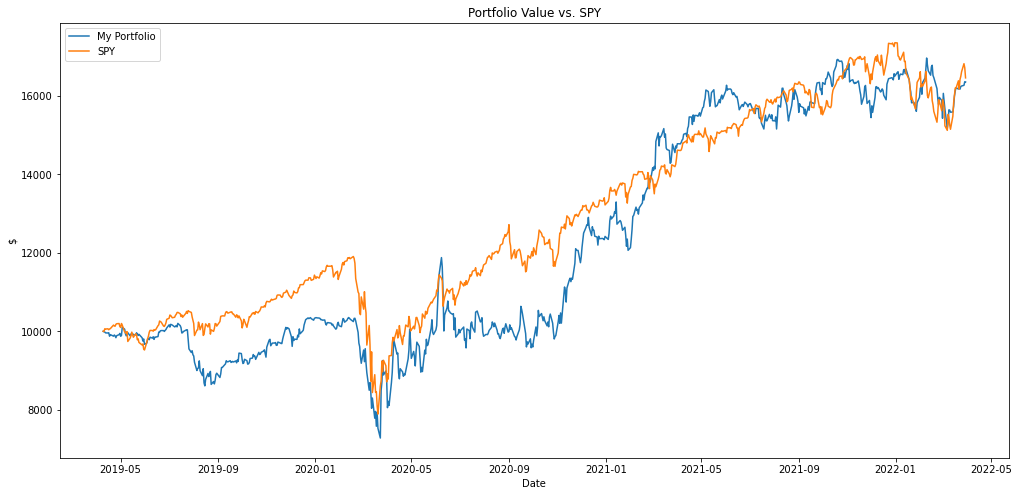

In [538]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

# Topic 1

In [539]:
vectorizer1 = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf1 = vectorizer1.fit_transform(topic1['title/clean'].tolist())
tfidf1 = tfidf1.toarray()
tfidf1

array([[0.        , 0.04093294, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.04250171,
        0.        ],
       [0.06341526, 0.        , 0.        , ..., 0.08968656, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03090507,
        0.        ]])

In [540]:
tfidf_pd1 = pd.DataFrame(tfidf1)
tfidf_pd1['Symbol'] = topic1['Symbol'].reset_index()['Symbol']
tfidf_pd1['Date'] = topic1['Date'].reset_index()['Date']
tfidf_pd1['currentPrice'] = topic1['current_price'].reset_index()['current_price']
tfidf_pd1['nextMonthDate'] = topic1['Date'].reset_index()['Date'] + pd.DateOffset(days = 30)
tfidf_pd1['next_price'] = topic1['next_price'].reset_index()['next_price']
tfidf_pd1['nextMonthPrice'] = topic1['nextMonthPrice'].reset_index()['nextMonthPrice']
tfidf_pd1.index = topic1.index
tfidf_pd1

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,Date,currentPrice,nextMonthDate,next_price,nextMonthPrice
0,0.000000,0.040933,0.000000,0.000000,0.045147,0.000000,0.039666,0.000000,0.051536,0.000000,...,0.0,0.000000,0.000000,0.0,MO,2021-04-20,43.927376,2021-05-20,44.541744,46.571022
1,0.000000,0.000000,0.000000,0.052651,0.000000,0.067612,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,MO,2020-07-28,37.373661,2020-08-27,38.322945,38.454792
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,MO,2020-03-19,31.058229,2020-04-18,31.155531,35.138142
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080607,...,0.0,0.000000,0.055082,0.0,MO,2019-08-30,35.339691,2019-09-29,34.595566,33.047379
4,0.000000,0.000000,0.069543,0.000000,0.000000,0.000000,0.033908,0.039696,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,AMZN,2022-02-03,2776.909912,2022-03-05,3065.870117,2912.820068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,0.000000,0.000000,0.000000,0.000000,0.000000,0.079573,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.051519,0.0,WYNN,2021-02-03,108.419998,2021-03-05,131.595734,133.320007
3657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,WYNN,2021-02-03,108.419998,2021-03-05,108.309013,133.320007
3658,0.000000,0.000000,0.000000,0.000000,0.065007,0.065646,0.000000,0.066864,0.000000,0.000000,...,0.0,0.000000,0.042502,0.0,XLNX,2020-09-29,103.336380,2020-10-29,116.489014,122.551788
3659,0.063415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.089687,0.000000,0.0,ZTS,2020-05-29,138.037415,2020-06-28,246.633926,131.372726


In [799]:
#date_split = '2019-03-30'
date_split = '2018-12-30'
X_train = tfidf_pd1[tfidf_pd1['Date'] < date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd1[tfidf_pd1['Date'] < date_split]['nextMonthPrice']
X_test = tfidf_pd1[tfidf_pd1['Date'] >= date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd1[tfidf_pd1['Date'] >= date_split]['nextMonthPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
13/13 [==============================] - 2s 2ms/step - loss: 56502.6094 - mean_absolute_error: 149.4893
Epoch 2/10
13/13 [==============================] - 0s 2ms/step - loss: 55419.0742 - mean_absolute_error: 148.0074
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 53767.5078 - mean_absolute_error: 145.7263
Epoch 4/10
13/13 [==============================] - 0s 2ms/step - loss: 51383.9141 - mean_absolute_error: 142.3224
Epoch 5/10
13/13 [==============================] - 0s 2ms/step - loss: 47844.3125 - mean_absolute_error: 137.0288
Epoch 6/10
13/13 [==============================] - 0s 2ms/step - loss: 42163.4375 - mean_absolute_error: 128.2631
Epoch 7/10
13/13 [==============================] - 0s 2ms/step - loss: 33600.4805 - mean_absolute_error: 113.9926
Epoch 8/10
13/13 [==============================] - 0s 2ms/step - loss: 20979.9395 - mean_absolute_error: 87.8933
Epoch 9/10
13/13 [==============================] - 0s 2ms/step - loss: 7664.7373

In [800]:
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd1.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd1.loc[X_test.index]['Date']
predicted['Symbol'] = tfidf_pd1.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
0,43.927376,54.159599,23.293501,46.571022,2021-04-20,MO
1,37.373661,46.401321,24.155141,38.454792,2020-07-28,MO
2,31.058229,39.635632,27.617164,35.138142,2020-03-19,MO
3,35.339691,43.237961,22.349572,33.047379,2019-08-30,MO
4,2776.909912,2839.603760,2.257684,2912.820068,2022-02-03,AMZN
...,...,...,...,...,...,...
3656,108.419998,118.100220,8.928447,133.320007,2021-02-03,WYNN
3657,108.419998,118.264648,9.080106,133.320007,2021-02-03,WYNN
3658,103.336380,114.446045,10.750972,122.551788,2020-09-29,XLNX
3659,138.037415,148.590714,7.645245,131.372726,2020-05-29,ZTS


In [801]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx
89897,2019-01-03,34.464798,AAPL,34.464798,0
89898,2019-01-04,35.936081,AAPL,34.464798,0
89899,2019-01-07,35.856094,AAPL,34.464798,0
89900,2019-01-08,36.539612,AAPL,34.464798,0
89901,2019-01-09,37.160126,AAPL,34.464798,0
...,...,...,...,...,...
60468,2022-03-24,16.719999,AAL,16.290001,771
60469,2022-03-25,17.010000,AAL,16.290001,771
60470,2022-03-28,17.299999,AAL,16.290001,771
60471,2022-03-29,18.160000,AAL,16.290001,771


In [802]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2019-01-03,10000.000000
0,2019-01-04,10042.689441
0,2019-01-07,10040.368622
0,2019-01-08,10060.200958
0,2019-01-09,10088.738221
...,...,...
0,2022-03-24,13931.254071
0,2022-03-25,13992.140661
0,2022-03-28,14000.859601
0,2022-03-29,14030.368328


In [803]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
938,239.216904,2019-01-04,1.000000,10000.000000
939,241.103043,2019-01-07,1.007885,10078.846389
940,243.368271,2019-01-08,1.017354,10173.539876
941,244.505646,2019-01-09,1.022109,10221.085633
942,245.368149,2019-01-10,1.025714,10257.140905
...,...,...,...,...
1750,452.690002,2022-03-25,1.892383,18923.830025
1751,455.910004,2022-03-28,1.905844,19058.435948
1752,461.549988,2022-03-29,1.929420,19294.204577
1753,458.700012,2022-03-30,1.917507,19175.066859


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

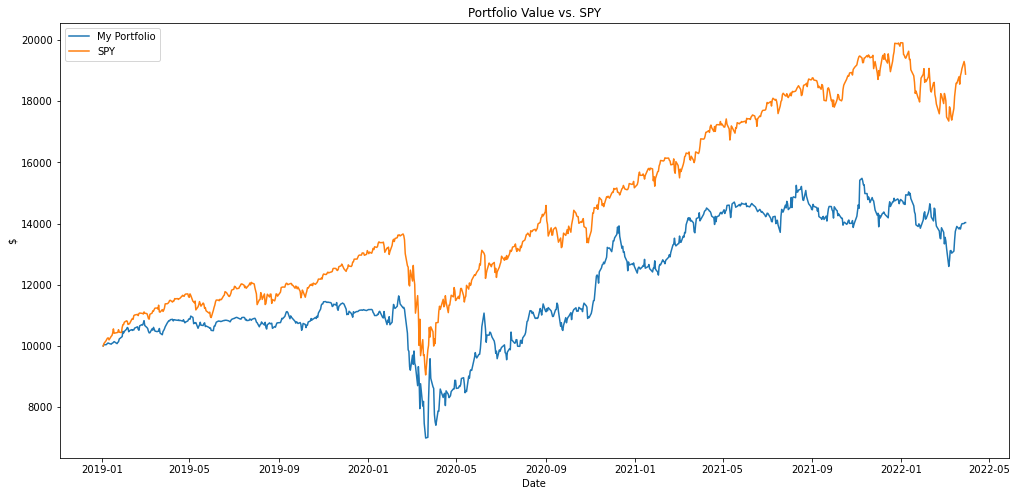

In [804]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
89897,2019-01-03,34.464798,AAPL,34.464798,0,Buy
89898,2019-01-04,35.936081,AAPL,34.464798,0,Buy
89899,2019-01-07,35.856094,AAPL,34.464798,0,Buy
89900,2019-01-08,36.539612,AAPL,34.464798,0,Buy
89901,2019-01-09,37.160126,AAPL,34.464798,0,Buy
...,...,...,...,...,...,...
60468,2022-03-24,16.719999,AAL,16.290001,608,Buy
60469,2022-03-25,17.010000,AAL,16.290001,608,Buy
60470,2022-03-28,17.299999,AAL,16.290001,608,Buy
60471,2022-03-29,18.160000,AAL,16.290001,608,Buy


,Date,Total
0,2019-01-03,10000.000000
0,2019-01-04,10085.378882
0,2019-01-07,10080.737243
0,2019-01-08,10120.401915
0,2019-01-09,10177.476442
...,...,...
0,2022-03-24,11529.127334
0,2022-03-25,11552.999311
0,2022-03-28,11561.718252
0,2022-03-29,11591.226979


,Close,Date,Cumul. Return,SPY_Total
938,239.216904,2019-01-04,1.000000,10000.000000
939,241.103043,2019-01-07,1.007885,10078.846389
940,243.368271,2019-01-08,1.017354,10173.539876
941,244.505646,2019-01-09,1.022109,10221.085633
942,245.368149,2019-01-10,1.025714,10257.140905
...,...,...,...,...
1750,452.690002,2022-03-25,1.892383,18923.830025
1751,455.910004,2022-03-28,1.905844,19058.435948
1752,461.549988,2022-03-29,1.929420,19294.204577
1753,458.700012,2022-03-30,1.917507,19175.066859


Text(0.5, 1.0, 'Topic 1: Portfolio Value vs. SPY')

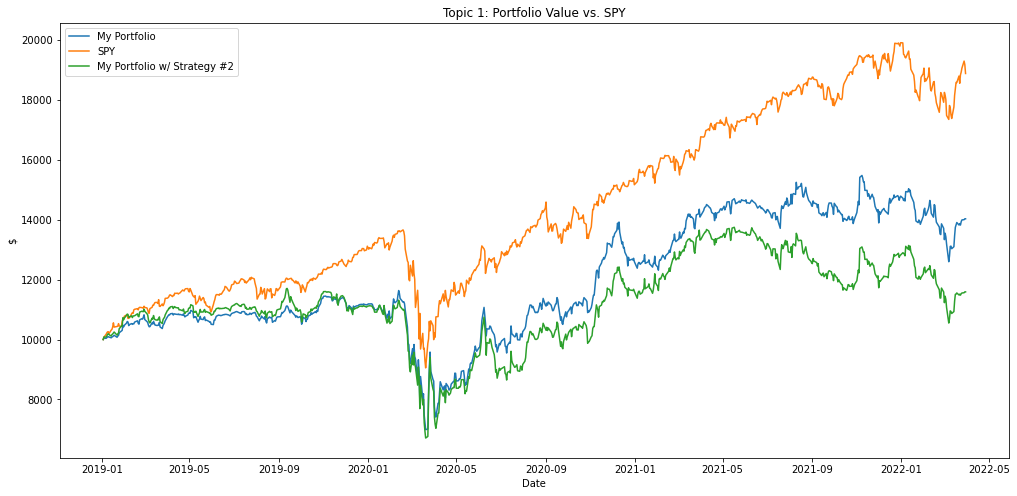

In [805]:
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] > 20:
                if buying_power >= 1000:
                    buying_power -= 1000
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['idx'] = tmp.index[j]
                    test2['BuyOrShort'] = 'Buy'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['idx'] = tmp.index[j]
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['idx'] = tmp.index[j]
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['idx'] = tmp.index[j]
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings
            
display(all_holdings)

portfolio_vals1 = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals1 = portfolio_vals1.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals1)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals1)):
    tmp = spy[spy['Date'] >= str(portfolio_vals1.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.plot(portfolio_vals1['Date'], portfolio_vals1['Total'], label = 'My Portfolio w/ Strategy #2')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Topic 1: Portfolio Value vs. SPY')

# Topic 2

In [548]:
vectorizer2 = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf2 = vectorizer2.fit_transform(topic2['title/clean'].tolist())
tfidf2 = tfidf2.toarray()
tfidf_pd2 = pd.DataFrame(tfidf2)
tfidf_pd2['Symbol'] = topic2['Symbol'].reset_index()['Symbol']
tfidf_pd2['Date'] = topic2['Date'].reset_index()['Date']
tfidf_pd2['nextMonthDate'] = topic2['Date'].reset_index()['Date'] + pd.DateOffset(days = 30)
tfidf_pd2['currentPrice'] = topic2['current_price'].reset_index()['current_price']
tfidf_pd2['next_price'] = topic2['next_price'].reset_index()['next_price']
tfidf_pd2['nextMonthPrice'] = topic2['nextMonthPrice'].reset_index()['nextMonthPrice']
tfidf_pd2.index = topic2.index
tfidf_pd2

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,Date,nextMonthDate,currentPrice,next_price,nextMonthPrice
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.048482,0.0,0.000000,0.000000,MO,2022-03-17,2022-04-16,50.815872,52.250000,54.110001
1,0.000000,0.000000,0.021809,0.0,0.023578,0.022987,0.0,0.0,0.000000,0.048923,...,0.062873,0.0,0.000000,0.052244,MO,2019-12-18,2020-01-17,42.295364,41.782112,42.711349
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.048549,0.000000,...,0.020150,0.0,0.026221,0.000000,MO,2019-11-12,2019-12-12,38.704872,40.533058,41.117752
3,0.045043,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.065913,MO,2019-09-24,2019-10-24,33.541477,34.587337,38.671932
4,0.043566,0.054451,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.029849,...,0.012787,0.0,0.016640,0.191255,MO,2019-05-22,2019-06-21,42.022060,39.524433,38.781551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8399,0.000000,0.000000,0.000000,0.0,0.000000,0.111492,0.0,0.0,0.000000,0.000000,...,0.050824,0.0,0.066138,0.000000,ZTS,2020-05-11,2020-06-10,125.163574,88.229805,138.552383
8400,0.000000,0.000000,0.000000,0.0,0.000000,0.199217,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.118177,0.000000,ZTS,2020-04-28,2020-05-28,121.806465,87.063980,136.769836
8401,0.000000,0.000000,0.000000,0.0,0.000000,0.199217,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.118177,0.000000,ZTS,2020-04-27,2020-05-27,126.183578,89.679741,134.323822
8402,0.000000,0.000000,0.000000,0.0,0.000000,0.199217,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.118177,0.000000,ZTS,2020-04-25,2020-05-25,124.688232,81.213638,128.847473


In [809]:
#date_split = '2019-03-30'
date_split = '2018-12-30'
X_train = tfidf_pd2[tfidf_pd2['Date'] < date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd2[tfidf_pd2['Date'] < date_split]['nextMonthPrice']
X_test = tfidf_pd2[tfidf_pd2['Date'] >= date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd2[tfidf_pd2['Date'] >= date_split]['nextMonthPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
35/35 [==============================] - 2s 2ms/step - loss: 141156.9531 - mean_absolute_error: 167.8631
Epoch 2/10
35/35 [==============================] - 0s 3ms/step - loss: 128547.1797 - mean_absolute_error: 159.7561
Epoch 3/10
35/35 [==============================] - 0s 2ms/step - loss: 86899.8359 - mean_absolute_error: 128.7089
Epoch 4/10
35/35 [==============================] - 0s 2ms/step - loss: 17036.4121 - mean_absolute_error: 46.0926
Epoch 5/10
35/35 [==============================] - 0s 2ms/step - loss: 1095.8335 - mean_absolute_error: 16.5020
Epoch 6/10
35/35 [==============================] - 0s 2ms/step - loss: 829.5157 - mean_absolute_error: 13.1827
Epoch 7/10
35/35 [==============================] - 0s 2ms/step - loss: 815.6768 - mean_absolute_error: 13.2614
Epoch 8/10
35/35 [==============================] - 0s 2ms/step - loss: 808.1705 - mean_absolute_error: 12.4328
Epoch 9/10
35/35 [==============================] - 0s 2ms/step - loss: 803.6893 - mean_ab

In [810]:
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd2.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd2.loc[X_test.index]['Date']
predicted['Symbol'] = tfidf_pd2.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
1,42.295364,49.349224,16.677619,42.711349,2019-12-18,MO
2,38.704872,43.800266,13.164736,41.117752,2019-11-12,MO
3,33.541477,39.394794,17.450982,38.671932,2019-09-24,MO
4,42.022060,47.961575,14.134276,38.781551,2019-05-22,MO
5,38.584751,43.424969,12.544379,41.368813,2019-02-01,MO
...,...,...,...,...,...,...
8398,84.289085,89.891464,6.646624,88.876434,2020-06-30,YUM
8399,125.163574,130.556381,4.308607,138.552383,2020-05-11,ZTS
8400,121.806465,126.048836,3.482878,136.769836,2020-04-28,ZTS
8401,126.183578,130.438766,3.372220,134.323822,2020-04-27,ZTS


In [811]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx
89897,2019-01-03,34.464798,AAPL,34.464798,0
89898,2019-01-04,35.936081,AAPL,34.464798,0
89899,2019-01-07,35.856094,AAPL,34.464798,0
89900,2019-01-08,36.539612,AAPL,34.464798,0
89901,2019-01-09,37.160126,AAPL,34.464798,0
...,...,...,...,...,...
898263,2022-03-24,38.820000,TWTR,35.560001,885
898264,2022-03-25,38.599998,TWTR,35.560001,885
898265,2022-03-28,39.119999,TWTR,35.560001,885
898266,2022-03-29,40.689999,TWTR,35.560001,885


In [812]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2019-01-03,10000.000000
0,2019-01-04,10042.689441
0,2019-01-07,10040.368622
0,2019-01-08,10072.384056
0,2019-01-09,10128.701846
...,...,...
0,2022-03-24,14199.955270
0,2022-03-25,14202.052455
0,2022-03-28,14206.870213
0,2022-03-29,14264.165761


In [813]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
938,239.216904,2019-01-04,1.000000,10000.000000
939,241.103043,2019-01-07,1.007885,10078.846389
940,243.368271,2019-01-08,1.017354,10173.539876
941,244.505646,2019-01-09,1.022109,10221.085633
942,245.368149,2019-01-10,1.025714,10257.140905
...,...,...,...,...
1750,452.690002,2022-03-25,1.892383,18923.830025
1751,455.910004,2022-03-28,1.905844,19058.435948
1752,461.549988,2022-03-29,1.929420,19294.204577
1753,458.700012,2022-03-30,1.917507,19175.066859


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

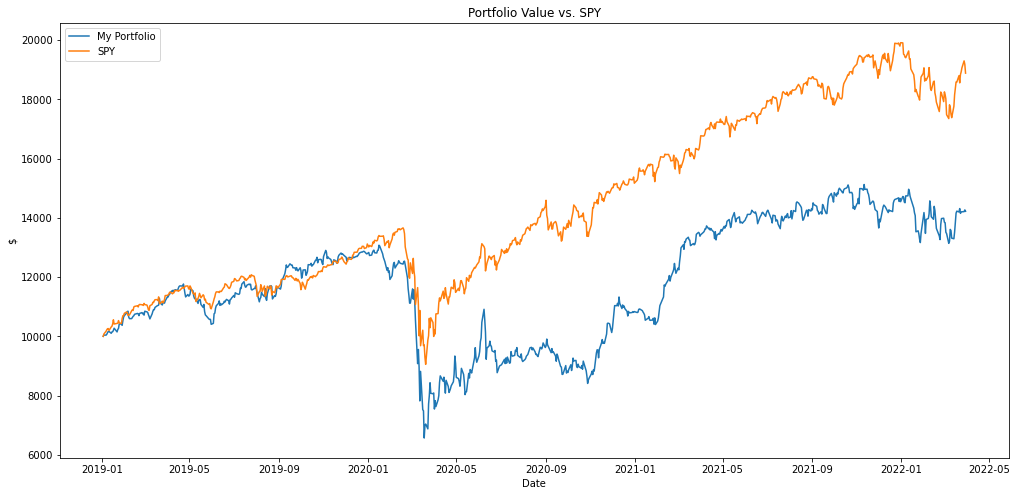

In [814]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
89897,2019-01-03,34.464798,AAPL,34.464798,0,Buy
89898,2019-01-04,35.936081,AAPL,34.464798,0,Buy
89899,2019-01-07,35.856094,AAPL,34.464798,0,Buy
89900,2019-01-08,36.539612,AAPL,34.464798,0,Buy
89901,2019-01-09,37.160126,AAPL,34.464798,0,Buy
...,...,...,...,...,...,...
898262,2022-03-23,38.000000,TWTR,35.549999,792,Buy
898263,2022-03-24,38.820000,TWTR,35.549999,792,Buy
898264,2022-03-25,38.599998,TWTR,35.549999,792,Buy
898265,2022-03-28,39.119999,TWTR,35.549999,792,Buy


,Date,Total
0,2019-01-03,10000.000000
0,2019-01-04,10042.689441
0,2019-01-07,10040.368622
0,2019-01-08,10072.384056
0,2019-01-09,10128.701846
...,...,...
0,2022-03-23,13242.140326
0,2022-03-24,13275.006707
0,2022-03-25,13266.188845
0,2022-03-28,13273.179087


,Close,Date,Cumul. Return,SPY_Total
938,239.216904,2019-01-04,1.000000,10000.000000
939,241.103043,2019-01-07,1.007885,10078.846389
940,243.368271,2019-01-08,1.017354,10173.539876
941,244.505646,2019-01-09,1.022109,10221.085633
942,245.368149,2019-01-10,1.025714,10257.140905
...,...,...,...,...
1749,450.489990,2022-03-24,1.883186,18831.862769
1750,452.690002,2022-03-25,1.892383,18923.830025
1751,455.910004,2022-03-28,1.905844,19058.435948
1752,461.549988,2022-03-29,1.929420,19294.204577


Text(0.5, 1.0, 'Topic 2: Portfolio Value vs. SPY')

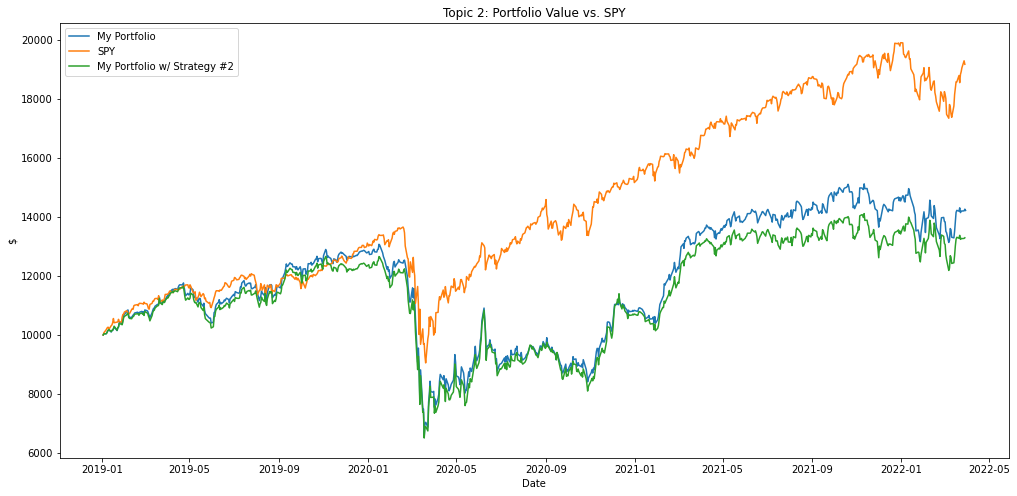

In [817]:
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] > 20:
                if buying_power >= 1000:
                    buying_power -= 1000
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['idx'] = tmp.index[j]
                    test2['BuyOrShort'] = 'Buy'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['idx'] = tmp.index[j]
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['idx'] = tmp.index[j]
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['idx'] = tmp.index[j]
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
display(all_holdings)

portfolio_vals2 = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals2 = portfolio_vals2.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals2)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals2)):
    tmp = spy[spy['Date'] >= str(portfolio_vals2.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals2['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.plot(portfolio_vals2['Date'], portfolio_vals2['Total'], label = 'My Portfolio w/ Strategy #2')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Topic 2: Portfolio Value vs. SPY')

In [438]:
predicted[predicted['percentChange'] < 0]

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol


# Topic 3

In [679]:
vectorizer3 = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf3 = vectorizer3.fit_transform(topic3['title/clean'].tolist())
tfidf3 = tfidf3.toarray()
tfidf_pd3 = pd.DataFrame(tfidf3)
tfidf_pd3['Symbol'] = topic3['Symbol'].reset_index()['Symbol']
tfidf_pd3['Date'] = topic3['Date'].reset_index()['Date']
tfidf_pd3['nextMonthDate'] = topic3['Date'].reset_index()['Date'] + pd.DateOffset(days = 30)
tfidf_pd3['currentPrice'] = topic3['current_price'].reset_index()['current_price']
tfidf_pd3['next_price'] = topic3['next_price'].reset_index()['next_price']
tfidf_pd3['nextMonthPrice'] = topic3['nextMonthPrice'].reset_index()['nextMonthPrice']
tfidf_pd3.index = topic3.index
tfidf_pd3

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,Date,nextMonthDate,currentPrice,next_price,nextMonthPrice
78,0.000000,0.000000,0.000000,0.0,0.056272,0.125201,0.000000,0.000000,0.019014,0.000000,...,0.000000,0.0,0.000000,0.0,MO,2019-05-20,2019-06-19,41.624352,39.850559,40.316658
227,0.000000,0.000000,0.000000,0.0,0.000000,0.036541,0.000000,0.000000,0.000000,0.000000,...,0.028324,0.0,0.000000,0.0,AMZN,2022-02-07,2022-03-09,3158.709961,3052.030029,2785.580078
230,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.046861,0.0,0.000000,0.0,AMZN,2022-02-04,2022-03-06,3152.790039,3093.050049,2912.820068
298,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.049484,0.0,0.067660,0.0,AMZN,2021-12-20,2022-01-19,3341.580078,3384.020020,3125.979980
299,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.045847,0.0,0.000000,0.0,AMZN,2021-12-20,2022-01-19,3341.580078,3384.020020,3125.979980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61460,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.027922,0.000000,0.000000,0.000000,...,0.043410,0.0,0.059355,0.0,XLNX,2020-09-03,2020-10-03,102.807884,100.020370,102.299324
61462,0.049537,0.000000,0.049968,0.0,0.000000,0.000000,0.000000,0.000000,0.016823,0.000000,...,0.000000,0.0,0.000000,0.0,XLNX,2020-09-03,2020-10-03,102.807884,111.972343,102.299324
61477,0.000000,0.051916,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.021730,0.000000,...,0.055455,0.0,0.000000,0.0,XLNX,2020-08-26,2020-09-25,104.682564,62.247452,100.065674
61481,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.119219,0.000000,...,0.000000,0.0,0.000000,0.0,XLNX,2020-08-26,2020-09-25,104.682564,65.832985,100.065674


In [818]:
#date_split = '2019-03-30'
date_split = '2018-12-30'
X_train = tfidf_pd3[tfidf_pd3['Date'] < date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd3[tfidf_pd3['Date'] < date_split]['nextMonthPrice']
X_test = tfidf_pd3[tfidf_pd3['Date'] >= date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd3[tfidf_pd3['Date'] >= date_split]['nextMonthPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
21/21 [==============================] - 2s 2ms/step - loss: 327995.4375 - mean_absolute_error: 286.4311
Epoch 2/10
21/21 [==============================] - 0s 2ms/step - loss: 320765.4062 - mean_absolute_error: 283.2844
Epoch 3/10
21/21 [==============================] - 0s 2ms/step - loss: 315890.2812 - mean_absolute_error: 281.0851
Epoch 4/10
21/21 [==============================] - 0s 2ms/step - loss: 306312.8750 - mean_absolute_error: 276.7506
Epoch 5/10
21/21 [==============================] - 0s 2ms/step - loss: 286944.3750 - mean_absolute_error: 267.7181
Epoch 6/10
21/21 [==============================] - 0s 2ms/step - loss: 253629.7656 - mean_absolute_error: 251.2384
Epoch 7/10
21/21 [==============================] - 0s 2ms/step - loss: 195068.0625 - mean_absolute_error: 219.3944
Epoch 8/10
21/21 [==============================] - 0s 2ms/step - loss: 109303.6875 - mean_absolute_error: 161.6911
Epoch 9/10
21/21 [==============================] - 0s 2ms/step - loss: 

In [819]:
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd3.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd3.loc[X_test.index]['Date']
predicted['Symbol'] = tfidf_pd3.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
78,41.624352,51.539383,23.820266,40.316658,2019-05-20,MO
227,3158.709961,3322.198242,5.175793,2785.580078,2022-02-07,AMZN
230,3152.790039,3316.059570,5.178573,2912.820068,2022-02-04,AMZN
298,3341.580078,3515.016602,5.190255,3125.979980,2021-12-20,AMZN
299,3341.580078,3512.834473,5.124953,3125.979980,2021-12-20,AMZN
...,...,...,...,...,...,...
61460,102.807884,115.262337,12.114297,102.299324,2020-09-03,XLNX
61462,102.807884,116.051445,12.881853,102.299324,2020-09-03,XLNX
61477,104.682564,117.480499,12.225470,100.065674,2020-08-26,XLNX
61481,104.682564,116.304825,11.102385,100.065674,2020-08-26,XLNX


In [744]:
predicted[predicted['percentChange'] == min(predicted['percentChange'])]

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
860,3055.290039,3071.595459,0.533678,3471.310059,2021-03-30,AMZN


In [820]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx
89895,2018-12-31,38.233898,AAPL,38.233898,0
89896,2019-01-02,38.277527,AAPL,38.233898,0
89897,2019-01-03,34.464798,AAPL,38.233898,0
89898,2019-01-04,35.936081,AAPL,38.233898,0
89899,2019-01-07,35.856094,AAPL,38.233898,0
...,...,...,...,...,...
499511,2022-03-24,129.250000,IBM,121.349998,1119
499512,2022-03-25,131.350006,IBM,121.349998,1119
499513,2022-03-28,131.470001,IBM,121.349998,1119
499514,2022-03-29,131.940002,IBM,121.349998,1119


In [821]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2018-12-31,10000.000000
0,2019-01-02,10000.570550
0,2019-01-03,9932.316117
0,2019-01-04,10066.838686
0,2019-01-07,10090.590126
...,...,...
0,2022-03-24,17582.744523
0,2022-03-25,17606.342956
0,2022-03-28,17614.414349
0,2022-03-29,17637.149279


In [822]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
936,237.122223,2019-01-02,1.000000,10000.000000
937,231.463821,2019-01-03,0.976137,9761.371945
938,239.216904,2019-01-04,1.008834,10088.337599
939,241.103043,2019-01-07,1.016788,10167.880499
940,243.368271,2019-01-08,1.026341,10263.410485
...,...,...,...,...
1750,452.690002,2022-03-25,1.909100,19090.998596
1751,455.910004,2022-03-28,1.922679,19226.793596
1752,461.549988,2022-03-29,1.946464,19464.644948
1753,458.700012,2022-03-30,1.934445,19344.454796


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

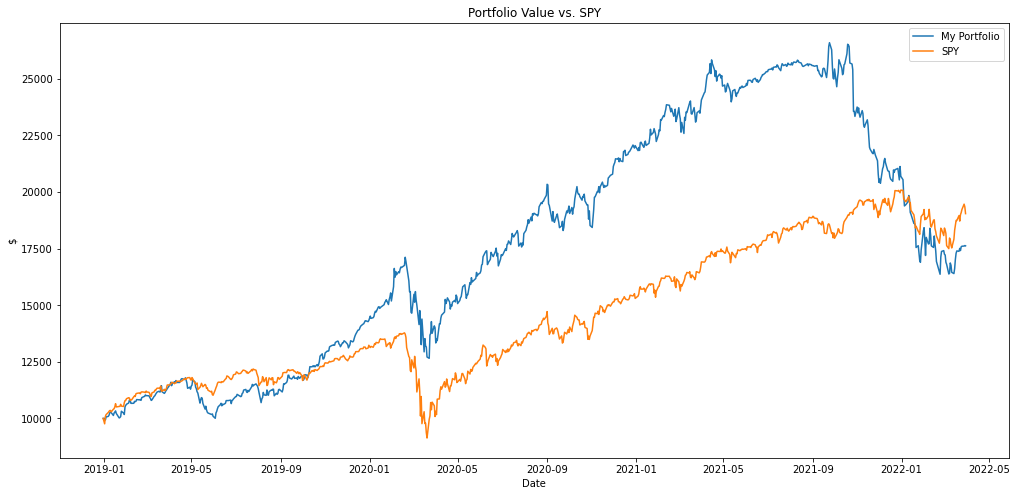

In [823]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
89895,2018-12-31,38.233898,AAPL,38.233898,0,Buy
89896,2019-01-02,38.277527,AAPL,38.233898,0,Buy
89897,2019-01-03,34.464798,AAPL,38.233898,0,Buy
89898,2019-01-04,35.936081,AAPL,38.233898,0,Buy
89899,2019-01-07,35.856094,AAPL,38.233898,0,Buy
...,...,...,...,...,...,...
499511,2022-03-24,129.250000,IBM,121.349998,1039,Buy
499512,2022-03-25,131.350006,IBM,121.349998,1039,Buy
499513,2022-03-28,131.470001,IBM,121.349998,1039,Buy
499514,2022-03-29,131.940002,IBM,121.349998,1039,Buy


,Date,Total
0,2018-12-31,10000.000000
0,2019-01-02,10001.141100
0,2019-01-03,9883.026084
0,2019-01-04,10100.823371
0,2019-01-07,10118.934666
...,...,...
0,2022-03-24,19375.558615
0,2022-03-25,19407.363444
0,2022-03-28,19420.724031
0,2022-03-29,19447.235934


,Close,Date,Cumul. Return,SPY_Total
936,237.122223,2019-01-02,1.000000,10000.000000
937,231.463821,2019-01-03,0.976137,9761.371945
938,239.216904,2019-01-04,1.008834,10088.337599
939,241.103043,2019-01-07,1.016788,10167.880499
940,243.368271,2019-01-08,1.026341,10263.410485
...,...,...,...,...
1750,452.690002,2022-03-25,1.909100,19090.998596
1751,455.910004,2022-03-28,1.922679,19226.793596
1752,461.549988,2022-03-29,1.946464,19464.644948
1753,458.700012,2022-03-30,1.934445,19344.454796


Text(0.5, 1.0, 'Topic 3: Portfolio Value vs. SPY')

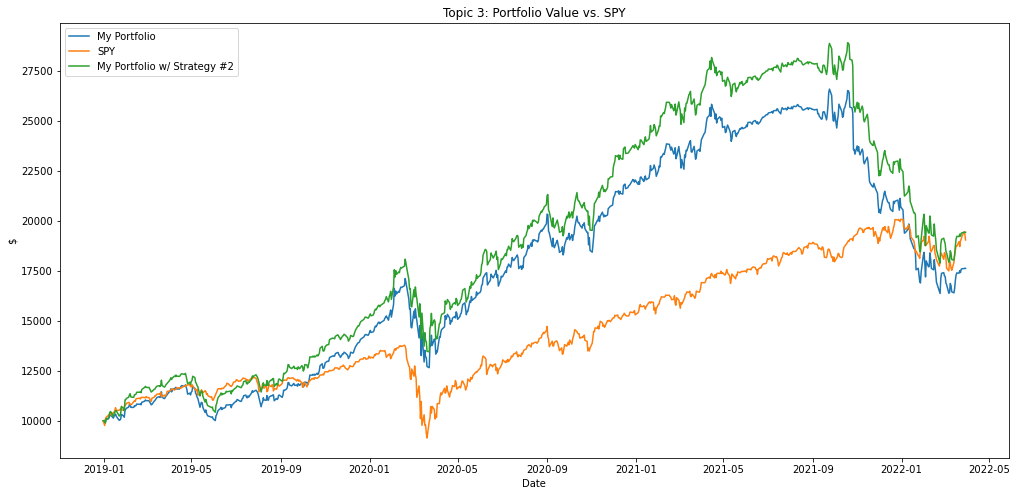

In [824]:
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] > 20:
                if buying_power >= 1000:
                    buying_power -= 1000
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['idx'] = tmp.index[j]
                    test2['BuyOrShort'] = 'Buy'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['idx'] = tmp.index[j]
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['idx'] = tmp.index[j]
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['idx'] = tmp.index[j]
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
            
display(all_holdings)

portfolio_vals3 = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals3 = portfolio_vals3.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals3)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals3)):
    tmp = spy[spy['Date'] >= str(portfolio_vals3.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.plot(portfolio_vals3['Date'], portfolio_vals3['Total'], label = 'My Portfolio w/ Strategy #2')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Topic 3: Portfolio Value vs. SPY')

In [682]:
current

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,idx,BuyOrShort
0,38.233898,45.299164,18.479062,40.054211,2018-12-31,AAPL,2019-01-30,500,7577,Buy
0,34.464798,41.471378,20.329672,40.362041,2019-01-03,AAPL,2019-02-02,1000,7559,Buy
0,34.464798,41.434135,20.221611,40.362041,2019-01-03,AAPL,2019-02-02,1000,7565,Buy
0,34.464798,42.701298,23.898297,40.362041,2019-01-03,AAPL,2019-02-02,1000,7571,Buy
0,60.071999,68.411095,13.881836,62.442001,2019-01-03,TSLA,2019-02-02,500,52311,Buy
...,...,...,...,...,...,...,...,...,...,...
0,35.290001,43.452271,23.129128,38.599998,2022-02-25,TWTR,2022-03-27,500,53662,Buy
0,35.290001,43.976421,24.614396,38.599998,2022-02-25,TWTR,2022-03-27,33.558453,53664,Buy
0,47.709999,54.576130,14.391387,51.509998,2022-02-26,INTC,2022-03-28,500,34259,Buy
0,46.129654,54.664967,18.502876,46.557240,2022-03-01,CMCSA,2022-03-31,500,24123,Buy


In [689]:
current[(current['dateSold'] > '2021-08-01') & (current['dateSold'] < '2022-01-01')]

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,idx,BuyOrShort
0,55.581749,63.780350,14.750527,52.781124,2021-07-05,INTC,2021-08-04,500,34363,Buy
0,38.657124,47.109917,21.866069,35.996117,2021-07-09,KHC,2021-08-08,1000,36614,Buy
0,54.651474,61.978924,13.407598,52.719524,2021-07-15,INTC,2021-08-14,500,34358,Buy
0,54.651474,61.502956,12.536684,52.719524,2021-07-15,INTC,2021-08-14,500,34359,Buy
0,44.433155,52.233608,17.555479,49.951984,2021-07-15,WFC,2021-08-14,500,59956,Buy
...,...,...,...,...,...,...,...,...,...,...
0,47.070000,55.338871,17.567179,44.160000,2021-11-26,TWTR,2021-12-26,500,54023,Buy
0,47.070000,54.053547,14.836514,44.330002,2021-11-27,TWTR,2021-12-27,500,54021,Buy
0,48.828045,56.017094,14.723196,51.348843,2021-11-30,INTC,2021-12-30,500,34156,Buy
0,43.939999,51.449291,17.089879,44.459999,2021-11-30,TWTR,2021-12-30,500,54004,Buy


In [692]:
df.loc[34363]['Article']

' By Hilary RussNEW YORK (Reuters) - Global esports revenues will hit $1.1 billion in 2019 up 27 percent since last year amid ballooning revenues from advertising sponsorship and media rights to competitive video gaming a report said on Tuesday.Brand investments through those three avenues will make up 82 percent - or $897 million - of total revenues. In all brand support will have nearly tripled since 2015 according to data from Newzoo a gaming industry analytics firm.Esports is a form of competitive video gaming with multiple players battling against each other usually in teams often in matches that are streamed live to throngs of young fans. Esports has burst into the mainstream with its own superstars and leagues celebrity athlete owners and tournaments that sell out stadiums and award prizes worth millions of dollars. League of Legends Dota 2 and Counter-Strike: Global Offensive are some of the most popular esports.Early investments by big brands are now taking root Newzoo CEO Pet

# Topic 4

In [564]:
vectorizer4 = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf4 = vectorizer4.fit_transform(topic4['title/clean'].tolist())
tfidf4 = tfidf4.toarray()
tfidf_pd4 = pd.DataFrame(tfidf4)
tfidf_pd4['Symbol'] = topic4['Symbol'].reset_index()['Symbol']
tfidf_pd4['Date'] = topic4['Date'].reset_index()['Date']
tfidf_pd4['nextMonthDate'] = topic4['Date'].reset_index()['Date'] + pd.DateOffset(days = 30)
tfidf_pd4['currentPrice'] = topic4['current_price'].reset_index()['current_price']
tfidf_pd4['next_price'] = topic4['next_price'].reset_index()['next_price']
tfidf_pd4['nextMonthPrice'] = topic4['nextMonthPrice'].reset_index()['nextMonthPrice']
tfidf_pd4.index = topic4.index
tfidf_pd4

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,Date,nextMonthDate,currentPrice,next_price,nextMonthPrice
0,0.033613,0.0,0.038107,0.000000,0.000000,0.000000,0.075986,0.0,0.038668,0.000000,...,0.0,0.0,0.024282,0.0,MO,2021-04-19,2021-05-19,45.686707,45.025795,46.021816
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.079873,0.000000,...,0.0,0.0,0.000000,0.0,MO,2020-07-10,2020-08-09,35.395988,36.784756,37.066021
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,MO,2020-07-09,2020-08-08,33.928116,36.547436,37.066021
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,MO,2020-06-26,2020-07-26,33.567738,35.395988,36.784756
4,0.000000,0.0,0.078851,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,MO,2020-06-15,2020-07-15,35.431152,34.481865,36.037636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715,0.143917,0.0,0.163160,0.000000,0.080565,0.083731,0.000000,0.0,0.041390,0.043322,...,0.0,0.0,0.051984,0.0,ZBH,2020-06-24,2020-07-24,113.158371,119.159637,128.643860
4716,0.028079,0.0,0.063667,0.130035,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.040569,0.0,ZBH,2020-06-24,2020-07-24,113.158371,117.270065,128.643860
4717,0.071636,0.0,0.081214,0.041469,0.000000,0.000000,0.040485,0.0,0.041204,0.086255,...,0.0,0.0,0.051750,0.0,ZTS,2020-04-25,2020-05-25,124.688232,78.574440,128.847473
4718,0.093759,0.0,0.035432,0.000000,0.069982,0.036366,0.035325,0.0,0.000000,0.037631,...,0.0,0.0,0.067732,0.0,ZTS,2020-04-23,2020-05-23,122.440254,44.554573,128.847473


In [825]:
#date_split = '2019-03-30'
date_split = '2018-12-30'
X_train = tfidf_pd4[tfidf_pd4['Date'] < date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd4[tfidf_pd4['Date'] < date_split]['nextMonthPrice']
X_test = tfidf_pd4[tfidf_pd4['Date'] >= date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd4[tfidf_pd4['Date'] >= date_split]['nextMonthPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
19/19 [==============================] - 1s 2ms/step - loss: 67086.3672 - mean_absolute_error: 122.2185
Epoch 2/10
19/19 [==============================] - 0s 2ms/step - loss: 57805.0000 - mean_absolute_error: 112.6591
Epoch 3/10
19/19 [==============================] - 0s 2ms/step - loss: 41630.1953 - mean_absolute_error: 94.6358
Epoch 4/10
19/19 [==============================] - 0s 2ms/step - loss: 19437.5820 - mean_absolute_error: 60.4789
Epoch 5/10
19/19 [==============================] - 0s 2ms/step - loss: 2552.4006 - mean_absolute_error: 17.9872
Epoch 6/10
19/19 [==============================] - 0s 1ms/step - loss: 608.1506 - mean_absolute_error: 14.9831
Epoch 7/10
19/19 [==============================] - 0s 1ms/step - loss: 432.0929 - mean_absolute_error: 11.3827
Epoch 8/10
19/19 [==============================] - 0s 1ms/step - loss: 424.4166 - mean_absolute_error: 10.3714
Epoch 9/10
19/19 [==============================] - 0s 1ms/step - loss: 412.0010 - mean_absol

In [826]:
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd4.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd4.loc[X_test.index]['Date']
predicted['Symbol'] = tfidf_pd4.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
0,45.686707,52.679550,15.306080,46.021816,2021-04-19,MO
1,35.395988,40.123428,13.355863,37.066021,2020-07-10,MO
2,33.928116,38.657986,13.940856,37.066021,2020-07-09,MO
3,33.567738,38.280064,14.038259,36.784756,2020-06-26,MO
4,35.431152,40.131123,13.265079,36.037636,2020-06-15,MO
...,...,...,...,...,...,...
4715,113.158371,118.870094,5.047548,128.643860,2020-06-24,ZBH
4716,113.158371,119.024017,5.183573,128.643860,2020-06-24,ZBH
4717,124.688232,130.075439,4.320542,128.847473,2020-04-25,ZTS
4718,122.440254,128.069977,4.597934,128.847473,2020-04-23,ZTS


In [827]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx
564128,2019-01-02,38.885002,LEN,38.885002,0
564129,2019-01-03,38.486031,LEN,38.885002,0
564130,2019-01-04,40.101387,LEN,38.885002,0
564131,2019-01-07,41.239914,LEN,38.885002,0
564132,2019-01-08,41.736187,LEN,38.885002,0
...,...,...,...,...,...
474112,2022-03-24,38.529999,HPQ,33.831146,696
474113,2022-03-25,39.840000,HPQ,33.831146,696
474114,2022-03-28,38.750000,HPQ,33.831146,696
474115,2022-03-29,39.720001,HPQ,33.831146,696


In [828]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2019-01-02,10000.000000
0,2019-01-03,9944.739607
0,2019-01-04,10117.627618
0,2019-01-07,10190.088522
0,2019-01-08,10234.235974
...,...,...
0,2022-03-24,13697.867742
0,2022-03-25,13805.804668
0,2022-03-28,13772.589460
0,2022-03-29,13772.531467


In [829]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
937,231.463821,2019-01-03,1.000000,10000.000000
938,239.216904,2019-01-04,1.033496,10334.958709
939,241.103043,2019-01-07,1.041645,10416.446127
940,243.368271,2019-01-08,1.051431,10514.311454
941,244.505646,2019-01-09,1.056345,10563.449798
...,...,...,...,...
1750,452.690002,2022-03-25,1.955770,19557.700192
1751,455.910004,2022-03-28,1.969681,19696.814858
1752,461.549988,2022-03-29,1.994048,19940.480762
1753,458.700012,2022-03-30,1.981735,19817.352423


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

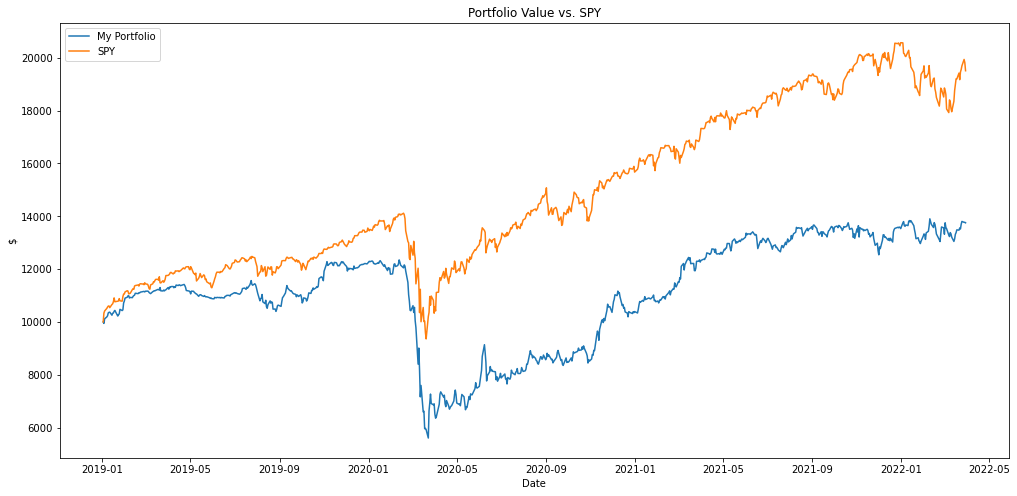

In [830]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
564128,2019-01-02,38.885002,LEN,38.885002,0,Buy
564129,2019-01-03,38.486031,LEN,38.885002,0,Buy
564130,2019-01-04,40.101387,LEN,38.885002,0,Buy
564131,2019-01-07,41.239914,LEN,38.885002,0,Buy
564132,2019-01-08,41.736187,LEN,38.885002,0,Buy
...,...,...,...,...,...,...
474112,2022-03-24,38.529999,HPQ,33.831146,647,Buy
474113,2022-03-25,39.840000,HPQ,33.831146,647,Buy
474114,2022-03-28,38.750000,HPQ,33.831146,647,Buy
474115,2022-03-29,39.720001,HPQ,33.831146,647,Buy


,Date,Total
0,2019-01-02,10000.000000
0,2019-01-03,9918.022089
0,2019-01-04,10139.185781
0,2019-01-07,10248.075630
0,2019-01-08,10292.505296
...,...,...
0,2022-03-24,15846.519760
0,2022-03-25,15978.685834
0,2022-03-28,15928.364835
0,2022-03-29,15913.912929


,Close,Date,Cumul. Return,SPY_Total
937,231.463821,2019-01-03,1.000000,10000.000000
938,239.216904,2019-01-04,1.033496,10334.958709
939,241.103043,2019-01-07,1.041645,10416.446127
940,243.368271,2019-01-08,1.051431,10514.311454
941,244.505646,2019-01-09,1.056345,10563.449798
...,...,...,...,...
1750,452.690002,2022-03-25,1.955770,19557.700192
1751,455.910004,2022-03-28,1.969681,19696.814858
1752,461.549988,2022-03-29,1.994048,19940.480762
1753,458.700012,2022-03-30,1.981735,19817.352423


Text(0.5, 1.0, 'Topic 4: Portfolio Value vs. SPY')

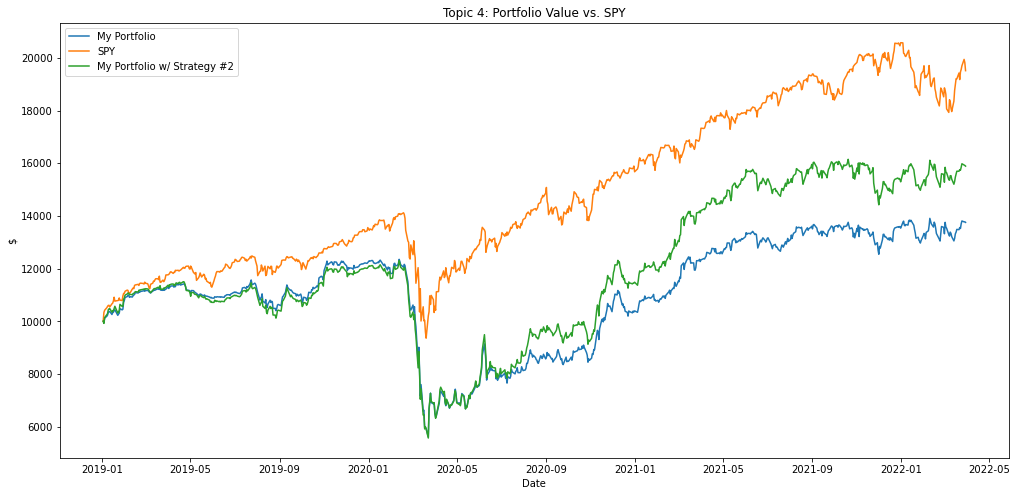

In [831]:
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] > 20:
                if buying_power >= 1000:
                    buying_power -= 1000
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['BuyOrShort'] = 'Buy'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
            
display(all_holdings)

portfolio_vals4 = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals4 = portfolio_vals4.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals4)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals4)):
    tmp = spy[spy['Date'] >= str(portfolio_vals4.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.plot(portfolio_vals4['Date'], portfolio_vals4['Total'], label = 'My Portfolio w/ Strategy #2')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Topic 4: Portfolio Value vs. SPY')

In [446]:
current

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,BuyOrShort
0,116.931969,131.818024,12.730526,120.499687,2018-12-31,CAT,2019-01-30,500,Buy
0,136.970001,151.499374,10.607705,149.160004,2018-12-31,CRM,2019-01-30,500,Buy
0,38.096794,50.819904,33.396800,46.186638,2019-01-01,LEN,2019-01-31,1000,Buy
0,57.382557,71.629242,24.827554,62.512314,2019-01-02,XOM,2019-02-01,1000,Buy
0,32.624866,43.650620,33.795550,39.448696,2019-01-02,MU,2019-02-01,1000,Buy
...,...,...,...,...,...,...,...,...,...
0,118.788582,132.986008,11.951844,136.889999,2022-02-24,CINF,2022-03-26,500,Buy
0,94.895935,109.418022,15.303171,109.080002,2022-02-24,HES,2022-03-26,398.934731,Buy
0,37.189999,50.253067,35.125219,36.450001,2022-02-25,IPG,2022-03-27,1000,Buy
0,43.189999,55.666214,28.886816,36.669998,2022-02-25,SYF,2022-03-27,430.904485,Buy


# Topic 5

In [572]:
vectorizer5 = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf5 = vectorizer5.fit_transform(topic5['title/clean'].tolist())
tfidf5 = tfidf5.toarray()
tfidf_pd5 = pd.DataFrame(tfidf5)
tfidf_pd5['Symbol'] = topic5['Symbol'].reset_index()['Symbol']
tfidf_pd5['Date'] = topic5['Date'].reset_index()['Date']
tfidf_pd5['nextMonthDate'] = topic5['Date'].reset_index()['Date'] + pd.DateOffset(days = 30)
tfidf_pd5['currentPrice'] = topic5['current_price'].reset_index()['current_price']
tfidf_pd5['next_price'] = topic5['next_price'].reset_index()['next_price']
tfidf_pd5['nextMonthPrice'] = topic5['nextMonthPrice'].reset_index()['nextMonthPrice']
tfidf_pd5.index = topic5.index
tfidf_pd5

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,Date,nextMonthDate,currentPrice,next_price,nextMonthPrice
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,MO,2022-02-24,2022-03-26,48.731728,50.363655,53.619999
1,0.000000,0.0,0.000000,0.080641,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.041343,0.0,0.0,0.000000,MO,2022-02-15,2022-03-17,49.469044,50.697903,50.815872
2,0.054821,0.0,0.000000,0.134024,0.075460,0.077016,0.0,0.000000,0.000000,0.0,...,0.068711,0.0,0.0,0.000000,MO,2021-10-28,2021-11-27,43.000420,43.309078,42.190182
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.097967,0.000000,0.0,...,0.042784,0.0,0.0,0.000000,MO,2021-04-27,2021-05-27,43.899448,46.943371,45.798409
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,MO,2021-04-20,2021-05-20,43.927376,44.541744,46.571022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14580,0.000000,0.0,0.000000,0.000000,0.000000,0.069773,0.0,0.000000,0.000000,0.0,...,0.031124,0.0,0.0,0.048846,ZTS,2020-05-13,2020-06-12,121.836174,192.231339,132.769043
14581,0.044946,0.0,0.057532,0.000000,0.000000,0.063143,0.0,0.000000,0.000000,0.0,...,0.028167,0.0,0.0,0.088409,ZTS,2020-05-11,2020-06-10,125.163574,89.219284,138.552383
14582,0.045869,0.0,0.000000,0.056069,0.031569,0.064439,0.0,0.032910,0.000000,0.0,...,0.057490,0.0,0.0,0.045112,ZTS,2020-04-25,2020-05-25,124.688232,87.259163,128.847473
14583,0.000000,0.0,0.000000,0.000000,0.000000,0.098619,0.0,0.000000,0.000000,0.0,...,0.043992,0.0,0.0,0.069040,ZTS,2020-04-24,2020-05-24,124.688232,44.554573,128.847473


In [832]:
#date_split = '2019-03-30'
date_split = '2018-12-30'
X_train = tfidf_pd5[tfidf_pd5['Date'] < date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd5[tfidf_pd5['Date'] < date_split]['nextMonthPrice']
X_test = tfidf_pd5[tfidf_pd5['Date'] >= date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd5[tfidf_pd5['Date'] >= date_split]['nextMonthPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
57/57 [==============================] - 2s 2ms/step - loss: 185774.4688 - mean_absolute_error: 203.3272
Epoch 2/10
57/57 [==============================] - 0s 2ms/step - loss: 163617.7656 - mean_absolute_error: 190.4650
Epoch 3/10
57/57 [==============================] - 0s 1ms/step - loss: 61779.2578 - mean_absolute_error: 106.2604
Epoch 4/10
57/57 [==============================] - 0s 1ms/step - loss: 1275.0155 - mean_absolute_error: 15.8227
Epoch 5/10
57/57 [==============================] - 0s 1ms/step - loss: 1098.9196 - mean_absolute_error: 14.1839
Epoch 6/10
57/57 [==============================] - 0s 1ms/step - loss: 1091.3357 - mean_absolute_error: 13.7995
Epoch 7/10
57/57 [==============================] - 0s 1ms/step - loss: 1097.5909 - mean_absolute_error: 13.4530
Epoch 8/10
57/57 [==============================] - 0s 1ms/step - loss: 1077.8473 - mean_absolute_error: 13.0240
Epoch 9/10
57/57 [==============================] - 0s 1ms/step - loss: 1079.4535 - mean

In [833]:
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd5.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd5.loc[X_test.index]['Date']
predicted['Symbol'] = tfidf_pd5.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
0,48.731728,50.984905,4.623636,53.619999,2022-02-24,MO
1,49.469044,52.768166,6.669063,50.815872,2022-02-15,MO
2,43.000420,45.952515,6.865270,42.190182,2021-10-28,MO
3,43.899448,47.053818,7.185442,45.798409,2021-04-27,MO
4,43.927376,46.891472,6.747719,46.571022,2021-04-20,MO
...,...,...,...,...,...,...
14580,121.836174,124.239120,1.972277,132.769043,2020-05-13,ZTS
14581,125.163574,128.395309,2.582009,138.552383,2020-05-11,ZTS
14582,124.688232,127.841248,2.528719,128.847473,2020-04-25,ZTS
14583,124.688232,128.036469,2.685286,128.847473,2020-04-24,ZTS


In [834]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx
89898,2019-01-04,35.936081,AAPL,35.936081,0
89899,2019-01-07,35.856094,AAPL,35.936081,0
89900,2019-01-08,36.539612,AAPL,35.936081,0
89901,2019-01-09,37.160126,AAPL,35.936081,0
89902,2019-01-10,37.278896,AAPL,35.936081,0
...,...,...,...,...,...
898263,2022-03-24,38.820000,TWTR,35.560001,464
898264,2022-03-25,38.599998,TWTR,35.560001,464
898265,2022-03-28,39.119999,TWTR,35.560001,464
898266,2022-03-29,40.689999,TWTR,35.560001,464


In [835]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2019-01-04,10000.000000
0,2019-01-07,9998.887099
0,2019-01-08,10036.991479
0,2019-01-09,10071.583569
0,2019-01-10,10078.204732
...,...,...
0,2022-03-24,19688.781038
0,2022-03-25,19682.329886
0,2022-03-28,19689.641478
0,2022-03-29,19711.716838


In [836]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
939,241.103043,2019-01-07,1.000000,10000.000000
940,243.368271,2019-01-08,1.009395,10093.952704
941,244.505646,2019-01-09,1.014113,10141.126512
942,245.368149,2019-01-10,1.017690,10176.899725
943,245.462982,2019-01-11,1.018083,10180.833038
...,...,...,...,...
1750,452.690002,2022-03-25,1.877579,18775.789702
1751,455.910004,2022-03-28,1.890934,18909.342609
1752,461.549988,2022-03-29,1.914327,19143.266829
1753,458.700012,2022-03-30,1.902506,19025.061121


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

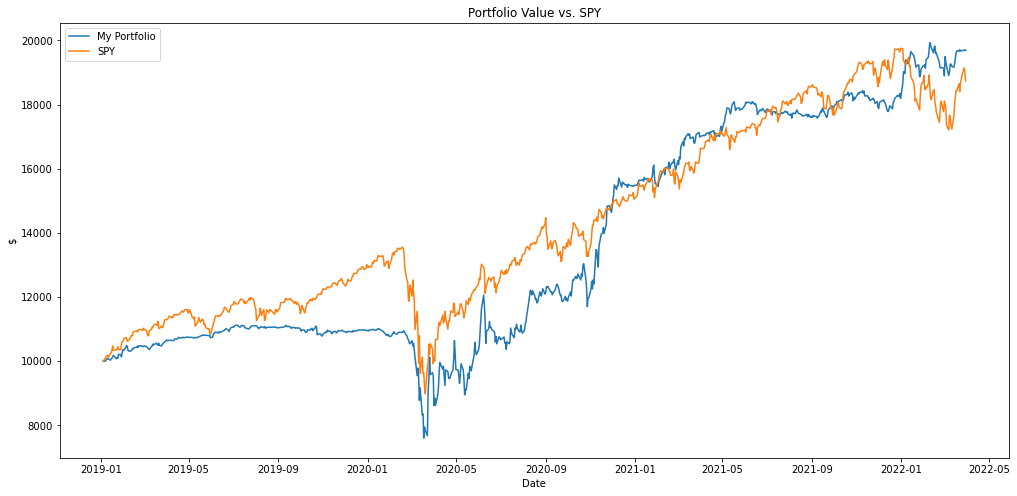

In [837]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
89898,2019-01-04,35.936081,AAPL,35.936081,0,Buy
89899,2019-01-07,35.856094,AAPL,35.936081,0,Buy
89900,2019-01-08,36.539612,AAPL,35.936081,0,Buy
89901,2019-01-09,37.160126,AAPL,35.936081,0,Buy
89902,2019-01-10,37.278896,AAPL,35.936081,0,Buy
...,...,...,...,...,...,...
898263,2022-03-24,38.820000,TWTR,35.560001,447,Buy
898264,2022-03-25,38.599998,TWTR,35.560001,447,Buy
898265,2022-03-28,39.119999,TWTR,35.560001,447,Buy
898266,2022-03-29,40.689999,TWTR,35.560001,447,Buy


,Date,Total
0,2019-01-04,10000.000000
0,2019-01-07,9998.887099
0,2019-01-08,10036.991479
0,2019-01-09,10071.583569
0,2019-01-10,10078.204732
...,...,...
0,2022-03-24,20424.357885
0,2022-03-25,20417.906733
0,2022-03-28,20425.218325
0,2022-03-29,20447.293685


,Close,Date,Cumul. Return,SPY_Total
939,241.103043,2019-01-07,1.000000,10000.000000
940,243.368271,2019-01-08,1.009395,10093.952704
941,244.505646,2019-01-09,1.014113,10141.126512
942,245.368149,2019-01-10,1.017690,10176.899725
943,245.462982,2019-01-11,1.018083,10180.833038
...,...,...,...,...
1750,452.690002,2022-03-25,1.877579,18775.789702
1751,455.910004,2022-03-28,1.890934,18909.342609
1752,461.549988,2022-03-29,1.914327,19143.266829
1753,458.700012,2022-03-30,1.902506,19025.061121


Text(0.5, 1.0, 'Topic 5: Portfolio Value vs. SPY')

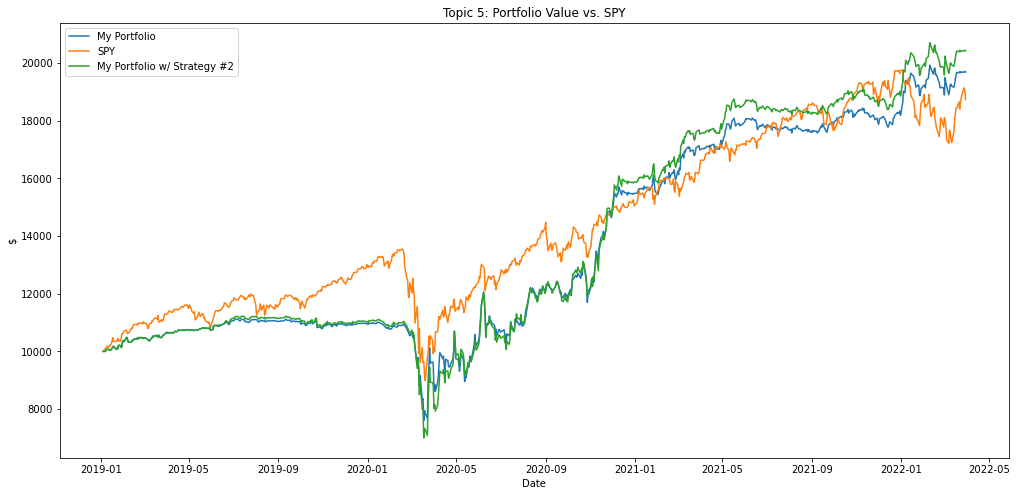

In [838]:
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] > 20:
                if buying_power >= 1000:
                    buying_power -= 1000
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['BuyOrShort'] = 'Buy'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
            
display(all_holdings)

portfolio_vals5 = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals5 = portfolio_vals5.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals5)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals5)):
    tmp = spy[spy['Date'] >= str(portfolio_vals5.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.plot(portfolio_vals5['Date'], portfolio_vals5['Total'], label = 'My Portfolio w/ Strategy #2')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Topic 5: Portfolio Value vs. SPY')

# Topic 6

In [580]:
vectorizer6 = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf6 = vectorizer6.fit_transform(topic6['title/clean'].tolist())
tfidf6 = tfidf6.toarray()
tfidf_pd6 = pd.DataFrame(tfidf6)
tfidf_pd6['Symbol'] = topic6['Symbol'].reset_index()['Symbol']
tfidf_pd6['Date'] = topic6['Date'].reset_index()['Date']
tfidf_pd6['nextMonthDate'] = topic6['Date'].reset_index()['Date'] + pd.DateOffset(days = 30)
tfidf_pd6['currentPrice'] = topic6['current_price'].reset_index()['current_price']
tfidf_pd6['next_price'] = topic6['next_price'].reset_index()['next_price']
tfidf_pd6['nextMonthPrice'] = topic6['nextMonthPrice'].reset_index()['nextMonthPrice']
tfidf_pd6.index = topic6.index
tfidf_pd6

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,Date,nextMonthDate,currentPrice,next_price,nextMonthPrice
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.054769,0.035191,0.0,...,0.062457,0.027012,0.0,0.0,MO,2022-01-27,2022-02-26,49.488705,49.331409,50.609425
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.103401,0.000000,0.0,0.0,MO,2021-10-26,2021-11-25,46.405338,43.202976,42.518135
2,0.0,0.0,0.0,0.065425,0.0,0.0,0.072113,0.036019,0.000000,0.0,...,0.041075,0.000000,0.0,0.0,MO,2021-04-20,2021-05-20,43.927376,44.541744,46.571022
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,MO,2021-04-20,2021-05-20,43.927376,44.541744,46.571022
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.030538,0.039244,0.0,...,0.000000,0.030123,0.0,0.0,MO,2021-04-20,2021-05-20,43.927376,44.541744,46.571022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19120,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.051974,0.0,0.0,ZTS,2020-05-14,2020-06-13,124.807060,226.066940,132.769043
19121,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.047899,0.0,0.0,ZTS,2020-05-13,2020-06-12,121.836174,206.471451,132.769043
19122,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.051620,0.0,0.0,ZTS,2020-05-12,2020-06-11,122.806664,200.916992,129.788239
19123,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.045043,0.0,0.0,ZTS,2020-05-12,2020-06-11,122.806664,203.270401,129.788239


In [780]:
#date_split = '2019-03-30'
date_split = '2018-12-30'
X_train = tfidf_pd6[tfidf_pd6['Date'] < date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd6[tfidf_pd6['Date'] < date_split]['nextMonthPrice']
X_test = tfidf_pd6[tfidf_pd6['Date'] >= date_split].drop(['Date', 'Symbol', 'next_price', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd6[tfidf_pd6['Date'] >= date_split]['nextMonthPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
72/72 [==============================] - 1s 2ms/step - loss: 114919.5781 - mean_absolute_error: 137.1253
Epoch 2/10
72/72 [==============================] - 0s 2ms/step - loss: 96131.6250 - mean_absolute_error: 124.3363
Epoch 3/10
72/72 [==============================] - 0s 2ms/step - loss: 14146.9980 - mean_absolute_error: 37.2530
Epoch 4/10
72/72 [==============================] - 0s 2ms/step - loss: 796.5233 - mean_absolute_error: 13.7715
Epoch 5/10
72/72 [==============================] - 0s 1ms/step - loss: 769.3294 - mean_absolute_error: 12.2745
Epoch 6/10
72/72 [==============================] - 0s 1ms/step - loss: 732.3442 - mean_absolute_error: 10.9425
Epoch 7/10
72/72 [==============================] - 0s 1ms/step - loss: 743.8017 - mean_absolute_error: 10.1520
Epoch 8/10
72/72 [==============================] - 0s 1ms/step - loss: 715.9728 - mean_absolute_error: 9.2505
Epoch 9/10
72/72 [==============================] - 0s 1ms/step - loss: 707.1666 - mean_absolute

In [582]:
len(tfidf_pd6[tfidf_pd6['Date'] < '2018-12-30'])

7127

In [781]:
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd6.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd6.loc[X_test.index]['Date']
predicted['Symbol'] = tfidf_pd6.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
0,49.488705,52.109898,5.296548,50.609425,2022-01-27,MO
1,46.405338,48.945042,5.472869,42.518135,2021-10-26,MO
2,43.927376,46.651672,6.201820,46.571022,2021-04-20,MO
3,43.927376,46.488308,5.829923,46.571022,2021-04-20,MO
4,43.927376,46.273293,5.340444,46.571022,2021-04-20,MO
...,...,...,...,...,...,...
19120,124.807060,129.055222,3.403783,132.769043,2020-05-14,ZTS
19121,121.836174,126.089943,3.491384,132.769043,2020-05-13,ZTS
19122,122.806664,126.959160,3.381328,129.788239,2020-05-12,ZTS
19123,122.806664,127.264870,3.630264,129.788239,2020-05-12,ZTS


In [783]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx
287349,2019-01-03,20.226788,DVN,20.226788,0
287350,2019-01-04,21.129770,DVN,20.226788,0
287351,2019-01-07,21.800556,DVN,20.226788,0
287352,2019-01-08,21.972549,DVN,20.226788,0
287353,2019-01-09,22.213346,DVN,20.226788,0
...,...,...,...,...,...
60467,2022-03-23,16.209999,AAL,17.250000,258
60468,2022-03-24,16.719999,AAL,17.250000,258
60469,2022-03-25,17.010000,AAL,17.250000,258
60470,2022-03-28,17.299999,AAL,17.250000,258


In [784]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2019-01-03,10000.000000
0,2019-01-04,10022.321456
0,2019-01-07,10038.903079
0,2019-01-08,10043.154699
0,2019-01-09,10049.107129
...,...,...
0,2022-03-23,17977.524227
0,2022-03-24,17991.597628
0,2022-03-25,18000.003452
0,2022-03-28,18008.409220


In [785]:
spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
938,239.216904,2019-01-04,1.000000,10000.000000
939,241.103043,2019-01-07,1.007885,10078.846389
940,243.368271,2019-01-08,1.017354,10173.539876
941,244.505646,2019-01-09,1.022109,10221.085633
942,245.368149,2019-01-10,1.025714,10257.140905
...,...,...,...,...
1749,450.489990,2022-03-24,1.883186,18831.862769
1750,452.690002,2022-03-25,1.892383,18923.830025
1751,455.910004,2022-03-28,1.905844,19058.435948
1752,461.549988,2022-03-29,1.929420,19294.204577


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

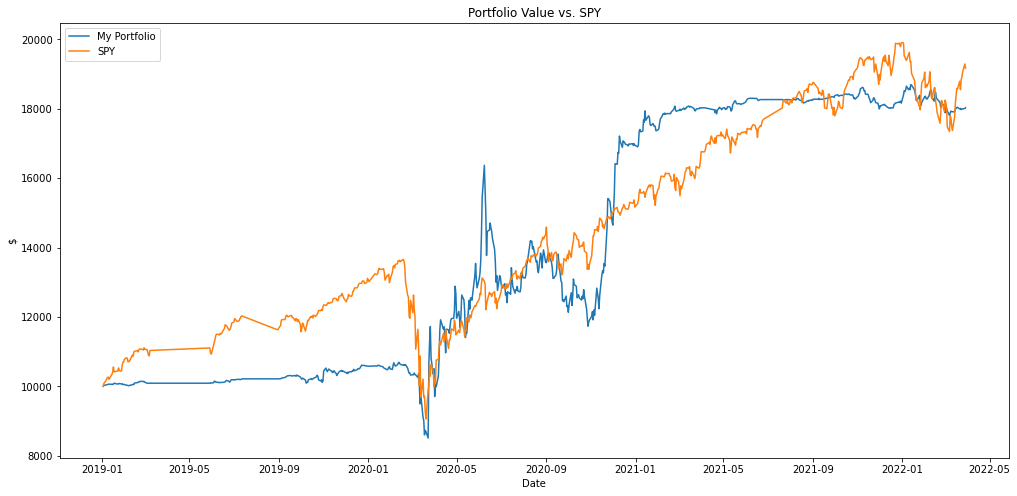

In [786]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
287349,2019-01-03,20.226788,DVN,20.226788,0,Buy
287350,2019-01-04,21.129770,DVN,20.226788,0,Buy
287351,2019-01-07,21.800556,DVN,20.226788,0,Buy
287352,2019-01-08,21.972549,DVN,20.226788,0,Buy
287353,2019-01-09,22.213346,DVN,20.226788,0,Buy
...,...,...,...,...,...,...
60467,2022-03-23,16.209999,AAL,17.250000,246,Buy
60468,2022-03-24,16.719999,AAL,17.250000,246,Buy
60469,2022-03-25,17.010000,AAL,17.250000,246,Buy
60470,2022-03-28,17.299999,AAL,17.250000,246,Buy


,Date,Total
0,2019-01-03,10000.000000
0,2019-01-04,10022.321456
0,2019-01-07,10038.903079
0,2019-01-08,10043.154699
0,2019-01-09,10049.107129
...,...,...
0,2022-03-23,15820.435609
0,2022-03-24,15834.509010
0,2022-03-25,15842.914833
0,2022-03-28,15851.320602


,Close,Date,Cumul. Return,SPY_Total
938,239.216904,2019-01-04,1.000000,10000.000000
939,241.103043,2019-01-07,1.007885,10078.846389
940,243.368271,2019-01-08,1.017354,10173.539876
941,244.505646,2019-01-09,1.022109,10221.085633
942,245.368149,2019-01-10,1.025714,10257.140905
...,...,...,...,...
1749,450.489990,2022-03-24,1.883186,18831.862769
1750,452.690002,2022-03-25,1.892383,18923.830025
1751,455.910004,2022-03-28,1.905844,19058.435948
1752,461.549988,2022-03-29,1.929420,19294.204577


Text(0.5, 1.0, 'Topic 6: Portfolio Value vs. SPY')

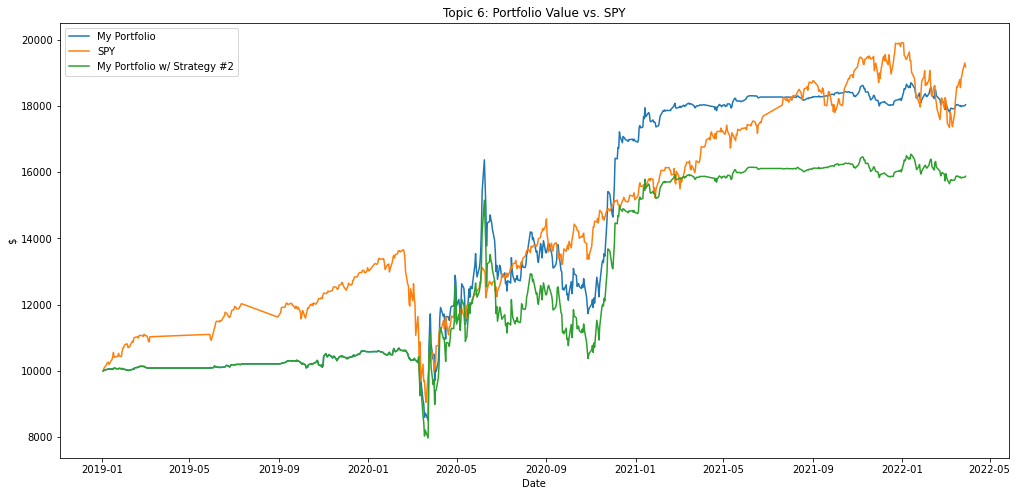

In [788]:
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] > 20:
                if buying_power >= 1000:
                    buying_power -= 1000
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['BuyOrShort'] = 'Buy'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
            
display(all_holdings)

portfolio_vals6 = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals6 = portfolio_vals6.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals6)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals6)):
    tmp = spy[spy['Date'] >= str(portfolio_vals6.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.plot(portfolio_vals6['Date'], portfolio_vals6['Total'], label = 'My Portfolio w/ Strategy #2')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Topic 6: Portfolio Value vs. SPY')

In [466]:
current

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,BuyOrShort
0,9.380830,10.351104,10.343157,7.445726,2020-03-09,APA,2020-04-08,500,Buy
0,11.950000,13.197951,10.443109,9.150000,2020-04-14,AAL,2020-05-14,500,Buy
0,9.280493,10.227490,10.204174,11.989766,2020-04-22,APA,2020-05-22,500,Buy
0,10.344498,11.921184,15.241783,11.989766,2020-04-23,APA,2020-05-23,500,Buy
0,10.792322,8.874563,-17.769660,11.507242,2020-04-29,HAL,2020-05-29,1000,Short
0,9.820000,10.807815,10.059215,11.850000,2020-05-04,AAL,2020-06-03,500,Buy
0,9.820000,11.341305,15.491906,11.850000,2020-05-04,AAL,2020-06-03,500,Buy
0,16.719999,18.460611,10.410359,12.500000,2020-06-04,AAL,2020-07-04,500,Buy
0,11.599874,12.906941,11.267949,10.046586,2020-09-18,OXY,2020-10-18,500,Buy


In [ ]:
# should i get the tfidf vector for overall df then split into topics or get the tfidf vector for each individual topic

In [ ]:
# short selling
# change how much spent depending on price prediction